## Imports

In [1]:
# BASICS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
# Configurer pandas pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

#UTILITARIES
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from sklearn import set_config
set_config(display = 'diagram', transform_output= "pandas")

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, TargetEncoder

# Model selection
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
import optuna, optuna_dashboard

#feature selection
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.inspection import permutation_importance

# pipelines
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, FunctionTransformer

# models
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


link: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 
ref score from before: 0.12804



# data Loading

In [2]:
data = pd.read_csv("data/train.csv",index_col="Id" )
data_test = pd.read_csv("data/test.csv",index_col="Id" )
#generate a copy to use during EDA
data_exp = data.copy()

# Notebook Structure

## I. EDA (Exploration & Decision Making)
**Goal:** Understand the data and make informed preprocessing decisions WITHOUT modifying the original dataset.
All transformations will be implemented in the Pipeline section.

### 1. Data Overview
   - Dataset info (shape, types)
   - Feature type corrections
   - Count numeric vs categorical features
   - Identify and document useless features


### 2. Duplicates
   - Check and delete for duplicate rows


### 3. Missing Values Analysis
   - Quantify missing values per feature
   - Distinguish "absence" (NA = "None") vs true missing data (domain knowledge)
   - **Decision:** Imputation strategy per feature

### 4. Numerical Features Analysis
   
   a) **Outliers Detection & Removal**
      - Identify extreme outliers (max vs P99)
      - Visualize with boxplots
      - **Action:** Remove aberrant rows NOW (won't be in pipeline)
      - Document removed rows for reproducibility
   
   b) **Skewness Analysis**
      - Calculate skewness for all numerical features
      - Test log transformation effect (before/after comparison)
      - **Decision:** Features requiring log transformation (|skewness| ≥ 1.5)
      - Identify zero-inflated distributions (bimodal)
      - 📝 **Output:** `to_log_transform` list
   
   c) **Distribution & Scaling Strategy**
      - Visualize distributions (histograms, QQ plots)
      - Assess presence of outliers (kurtosis, IQR)
      - **Decision:** Scaler type per feature group
      - 📝 **Output:** `to_minmax`, `to_robust`, `to_standard` lists
   
   d) **Cyclical Features**
      - Identify time-based cyclical features (MoSold)
      - **Decision:** Features requiring sine/cosine transformation
      - 📝 **Output:** `cyclical_features` list
   
   e) **Correlation Analysis**
      - Correlation matrix for numerical features
      - Identify highly correlated pairs (threshold > 0.9)
      - **Decision:** Features to possibly drop at some point due to redundancy

### 5. Categorical Features Analysis
   
   a) **Cardinality Analysis**
      - Count unique values per categorical feature
      - Identify high-cardinality features (> 10 unique values)
   
   b) **Ordinality Identification**
      - Domain knowledge: identify ordinal features (e.g., Quality: Po < Fa < TA < Gd < Ex)
      - Define ordering mappings
      - 📝 **Output:** `ordinal_mappings` dict
   
   c) **Distribution & Rare Categories**
      - Visualize value counts per category
      - Identify rare categories (< 5% threshold)
      - **Decision:** Rare category handling strategy
   
   d) **Encoding Strategy**
      - **Decision:** OneHot, Ordinal, or Target Encoding per feature
      - 📝 **Output:** `to_onehot`, `to_ordinal`, `to_target_encode` lists

### 6. Feature vs Target Relationships
   - Scatter plots: numerical features vs SalePrice
   - Boxplots: categorical features vs SalePrice distribution
   - Correlation with target
   - Identify most predictive features
   - **Insight:** Features to prioritize in feature engineering

### 7. EDA Summary
   - **Comprehensive decision table:** All preprocessing choices in one place
   - Key insights and patterns discovered
   - Warnings and caveats
   - Next steps for pipeline implementation

---

## II. Preprocessing Pipeline Implementation
**Goal:** Implement all EDA decisions in a sklearn pipeline.


### 2. Custom Transformers Definition
- definie the custom transformer (either class if statefull or function transformer if stateless)

### 3. Pipeline Construction
   
   a. **Preprocessing Steps (Sequential)**
      - Drop duplicates (FunctionTransformer)
      - Conditional imputation (Custom Transformer)
      - *Later* Log transformation (FunctionTransformer with `features_to_log`)
      - *Later* Cyclical transformation (FunctionTransformer)
      - *Later* Group rare unique categorical values (Custom Transformer)
   
   b. **Encoding & Scaling (ColumnTransformer)**
      - Ordinal encoding: `to_ordinal` with custom mappings
      - Target encoding: `to_target_encode` (requires y in fit)
      - OneHot encoding: `to_onehot` with handle_unknown='ignore'
      - *Later* MinMax scaling: `to_minmax` (discrete features)
      - *Later* Robust scaling: `to_robust` (continuous with outliers)
      - *Later* Standard scaling: `to_standard` (if needed)
   
   c. **Full Pipeline Assembly**
      - Combine preprocessing + encoding/scaling
  

### 4. Scorer Definition
   - Define RMSLE scorer (custom metric for Kaggle)
   - Define negative RMSLE for GridSearchCV

### 5. Pipeline Testing & Validation
   - Test pipeline on train set


---

## III. Baseline & Model Selection

### 1. Define baseline
- dummy model (predict the average of target price)
- quick and dirty pipeline (no scaling, no encoding, using CatBoost bc handle categorical features natively )

### 2. Base Models Comparison
   - **Linear models:** LinearRegression, Ridge, Lasso, ElasticNet
   - **Tree-based:** RandomForest, XGBoost, CatBoost
   - **Other:** KNN, SVR
   - Cross-validate with preprocessing pipeline
   - Compare RMSLE scores and training times

### 3. Iteration on preprocess
    - Update preprocess step to include the *Later* steps 
    - Rerun CV to update scores

### 4. Select Models
    - Select top 2,3 model based on score

---

## IV. Feature Selection (Optional)

### 1. Variance-Based Selection
   - VarianceThreshold: Remove quasi-constant features

### 2. Importance-Based Selection
   - Feature permutation importance
   - Filter by mean importance and stability
   - Tree-based feature importance (Gini, gain)

### 3. Evaluation
   - Compare scores before/after feature selection
   - Identify most important features

---

## V. Feature Engineering (Optional)

### 1. Engineer features

   - Zero-inflated decomposition (Has_Feature + Feature_log1p)
   - Domain Knowledge - based features. 

### 2. Evaluation
   - Test engineered features with top models
   - Compare scores before/after feature engineering

### 3. Re-Selection
   - If feature count explodes, re-apply feature selection

---

## VI. Hyperparameter Tuning

### 1. Optuna Search

### 2. Final Model Selection
   - Best pipeline with optimal hyperparameters
   - Final CV score

---

## VII. Final Evaluation & Submission

### 1. Train Final Model
   - Train best pipeline on full training set
   - Predict on Kaggle test set



# I. EDA

## I.1 dataset info

## I.2 Duplicates

In [4]:
duplicates_count = data_exp.duplicated().sum()


duplicate counts = 0, there are no duplicates


duplicates_count = data_exp.duplicated().sum()

In [5]:
# Convert MSSubclass into string (arbitrarily encoded categorical feature with no ordinality, to be reeconded later)
data_exp["MSSubClass"] = data_exp["MSSubClass"].astype(str)
num_df = data_exp.select_dtypes(include="number")
cat_df = data_exp.select_dtypes(exclude="number")


 There are 35 numerical features, including one time feature (month sold) 
 There are 44 categorical features


#### Feature Quality
- **No intrinsically useless features**: No IDs, URLs
- Variable predictive power: Some features likely have **low impact** on SalePrice 
  (e.g., Utilities, Street may have quasi-zero variance)
--> *VarianceThreshold and feature selection* will handle 
  

#### Feature Types
- Numeric and Categorical and 1 temporal. Type error already handled.
- Some categorical features have **high cardinality**. 
- Some categorical features have ordinality.  

#### Temporal Features
- **Year-based features**: YearBuilt, YearRemodAdd, GarageYrBlt, YrSold
- Transformation: *Will convert to ages* (House_Age, Years_Since_Remod, Garage_Age) 
  in preprocessing for:
  - Better interpretability (30 years vs 1994)
  - Temporal consistency across predictions

#### Conditional Features & Missing Values
- Logical structure: **Many features depend on others**:
  - Garage features (7) exist only if house has garage
  - Basement features (9) exist only if house has basement
  - Pool, Fireplace, Fence features similarly conditional

- **Missing values semantics**: 
  - NA often **means absence**, not true missing data_exp
  - Example: `GarageType = NA` means "no garage", not "unknown garage type"

- **Imputation strategy** (to be detailed in Missing Values section):
  - Categorical conditionals: NA → 'None' (indicating absence)
  - Numerical conditionals: NA → 0 (no area/count)
  - Temporal conditionals: GarageYrBlt → Garage_Age with median imputation
  - True missing values: domain-appropriate methods (median, mode, or predictive)




## I.3 Missing Values

### Cases where "NA" means "absence of characteristics

For those categorical features: impute "None"


In [6]:
# missing value count
missing_value = data_exp.isna().sum().sort_values(ascending= False)/len(data_exp)*100
missing_value[missing_value > 0]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

In [7]:
#list of categorical feature where "NA" means absence as per documentation
col_to_impute_na = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                    "Fence", "MiscFeature"]

#filling NA meaning absence of characteristic with "None"
data_exp[col_to_impute_na] = data_exp[col_to_impute_na].fillna("None")

### Case of veneer features

Still high number of MasVnrType (60%), not counted as "absence "in the documentation. Need to investigate whether these are real missing values.

- inspection of data_exp[["MasVnrType", "MasVnrArea"]] looks like MasVnrType that are NA are also with Area 0, so it doesnt seem missing at random. 

#### Analysis of NA, None, and 0 values for veneer type and area

In [8]:
# ===================
# missing data in VENEER AREA
# ===================
# number of NA-area houses
print(f"there are {len(data_exp[data_exp["MasVnrArea"].isna()])} houses with veneer area is NaN")
#number of 0-area houses
#house with no veneer (area = 0)
print(f" there are {len( data_exp[data_exp["MasVnrArea"] == 0])} houses with Vnr area = 0 \n")
# number of houses that are both NA-area and NA-type

#===================
# missing data in VENEER TYPE
#===================
#number of NA-type houses
print(f"there are {len(data_exp[data_exp["MasVnrType"].isna()])} NA-type houses")
#number of None-type houses
print(f" there are {len( data_exp[data_exp["MasVnrType"] == 'None'])} None-type houses \n")

#=========
# Patterns
#=========

# area = 0 & type = NA
print(f"Houses with area = 0, type = NA: {len( data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())])}")
print(f"representing {len(data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())] )/len( data_exp[data_exp["MasVnrArea"] == 0])}% of 0-area houses")
print(f"representing {len(data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())] )/len( data_exp[data_exp["MasVnrType"].isna()])}% of NA-type houses")
#area = 0 & type != NA
print(f"Houses with area = 0, type != NA: {len( data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].notna())])}")
#area  != 0 & type = NA
print(f"Houses with area > 0, type = NA: {len( data_exp[ (data_exp["MasVnrArea"] > 0) & (data_exp["MasVnrType"].isna())])}")
#area > 0 and type != NA (normal)

#area = NA & type != NA
print(f"Houses with area = NA, type != NA : {len(data_exp[(data_exp['MasVnrType'].notna()) & (data_exp['MasVnrArea'].isna())])}")
#area = NA & type = NA
print(f"Houses with area = NA, type = NA: {len(data_exp[  data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna()])}")


there are 8 houses with veneer area is NaN
 there are 861 houses with Vnr area = 0 

there are 872 NA-type houses
 there are 0 None-type houses 

Houses with area = 0, type = NA: 859
representing 0.9976771196283392% of 0-area houses
representing 0.9850917431192661% of NA-type houses
Houses with area = 0, type != NA: 2
Houses with area > 0, type = NA: 5
Houses with area = NA, type != NA : 0
Houses with area = NA, type = NA: 8


#### Conclusions and imputing strategy



No `'None'` values exist in `MasVnrType`, despite documentation specifying this as the standard encoding for absence of veneer.

- **859 houses**: `Area=0` and `Type=NA` (99.8% of zero-area houses and 98.5% of NA-type houses)
- **5 houses**: `Area>0` and `Type=NA` 
- **8 houses**: Both `Area=NA` and `Type=NA`
- **2 houses**: `Area=0` but `Type≠NA` (logical inconsistency)

If `Type=NA` represented true missing values, NAs would be distributed across all area values. Instead, they are concentrated where `Area=0`, indicating **`NA` implicitly encodes "no veneer"**. 

The 8 houses with both features NA likely represent true missing values (both features not collected), rather than dual encoding errors.

| Pattern | Count | Action | Rationale |
|---------|-------|--------|-----------|
| Area=0, Type=NA | 859 | Set `Type='None'` | Correct implicit encoding for absence |
| Area = 0, Type != NA | 2 | Drop rows | Logical inconsistency|
| Area > 0, Type = NA | 5 | Impute Mode | Likely true missing `Type` value  |
| Area = NA, Type = NA | 8 | Impute `Type` with mode and `Area` with mode | Likely missing values |

**Note**: For "both NA" cases, we impute conservatively with median area and mode type (calculated among houses with veneer), as these likely represent missing data_exp rather than absence. The imputation with mode should be done before encoding of "NA" into "None" otherwise "None" will be counted as the mode for this distribution. 





In [9]:
# drop rows where area = 0 and type != NA (unsolvable inconsistency)
row_to_drop = data_exp.loc[(data_exp["MasVnrType"].notna()) & (data_exp["MasVnrArea"] ==0), :].index
data_exp = data_exp.drop(index = row_to_drop)

# Impute mode for rows where area > 0 and type = NA (missing value)
type_mode = data_exp["MasVnrType"].mode()[0]
data_exp.loc[(data_exp["MasVnrArea"] > 0) & data_exp["MasVnrType"].isna(), "MasVnrType"] = type_mode

#impute Type mode and Area median for rows where area = NA and type = NA
area_median = data_exp["MasVnrArea"].median()
fill_values = {"MasVnrArea": area_median, "MasVnrType" : type_mode}
data_exp.loc[data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna(),["MasVnrType", "MasVnrArea"]] = data_exp.loc[data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna(),["MasVnrType", "MasVnrArea"]].fillna(value= fill_values)

# impute Type to "None" when Type is NA and area is 0
data_exp.loc[(data_exp["MasVnrType"].isna()) & (data_exp["MasVnrArea"] ==0), "MasVnrType"] = 'None'

### Handling LotFrontage and Electrical features

- roughly 6% of NA in electrical. Not an encoding of absence pas per documentation, and a house without electrical installation is unlikely --> consider as real NA and impute mode of the distribution. 

- LotFrontage, 17% of NA. Again, not encoding an absence as per documentation. Here again, rather unlikely to have a house unconnected to street. --> impute median

In [10]:
# Handling electrical
data_exp.loc[data_exp["Electrical"].isna(), "Electrical"] = data_exp["Electrical"].mode()[0]

#Handling LotFrontage missing data_exp
data_exp.loc[data_exp["LotFrontage"].isna(), "LotFrontage"] = data_exp["LotFrontage"].median()

### Handling of GarageYrBlt 

**Pattern observed**: All 73 houses with `GarageYrBlt=NA` also have other garage features indicating absence (`GarageType=NA`, `GarageArea=0`, etc.).

**Interpretation**: `NA` represents "no garage" (logical absence), not missing data.

**Handling strategy**: 
1. Convert all year features to ages (e.g., `GarageYrBlt` → `Garage_Age`)
2. Create binary indicator `Has_Garage` (0 = no garage, 1 = has garage)
3. For houses without garage: impute `Garage_Age` with median (calculated among houses with garages)

**Rationale**: 
- Cannot calculate age for non-existent garage 
- Median imputation provides neutral value that won't bias the model
- `Has_Garage` explicitly captures presence/absence
- Because it requires to transform numerical features (year), this missing value imputing step will be done during the Numerical Feature inspection part of EDA. 



In [11]:
# missing value count
missing_value = data_exp.isna().sum().sort_values(ascending= False)/len(data_exp)*100
missing_value[missing_value > 0]

GarageYrBlt    5.555556
dtype: float64

## I.4 Inspect Numerical Features


### Handling age conversion and garage age NA

In [12]:
year_features = ["GarageYrBlt", "YrSold","YearBuilt", "YearRemodAdd"]
#calculate house age at sell time
data_exp["House_age"] = data_exp["YrSold"] - data_exp["YearBuilt"]
# Add binary "remodelling" feature: 1 if remodelled, 0 if not
data_exp["Was_remodelled"] = (data_exp["YearRemodAdd"] != data_exp["YearBuilt"]).astype(int)

# Calculate remodelling age
data_exp["Remodelled_age"] = data_exp["YrSold"] - data_exp["YearRemodAdd"]

# Add binary "has garage" feature: 0 if no garage, 1 if garage
#data_exp["Has_garage"]  = (data_exp["GarageYrBlt"]).notna().astype(int)
# **Decision: Dropped Has_garage feature**
# Rationale: Garage presence/absence is already captured by multiple categorical garage features
# (GarageType, GarageQual, GarageCond, GarageFinish) that were imputed with "None" for houses without garages.


# Age of garage (will remain NA in absence of garage)
data_exp["Garage_age"] = data_exp["YrSold"] - data_exp["GarageYrBlt"]

#impute median garage age for rows where "Garage_age" = NA (meaning no garage)
median_garage_age = data_exp.loc[data_exp["GarageYrBlt"].notna(), "Garage_age"].median()
data_exp["Garage_age"] = data_exp["Garage_age"].fillna(value= median_garage_age)

data_exp = data_exp.drop(columns= year_features)

#update list of numerical features
num_df = data_exp.select_dtypes(include="number")


### Inspect outliers


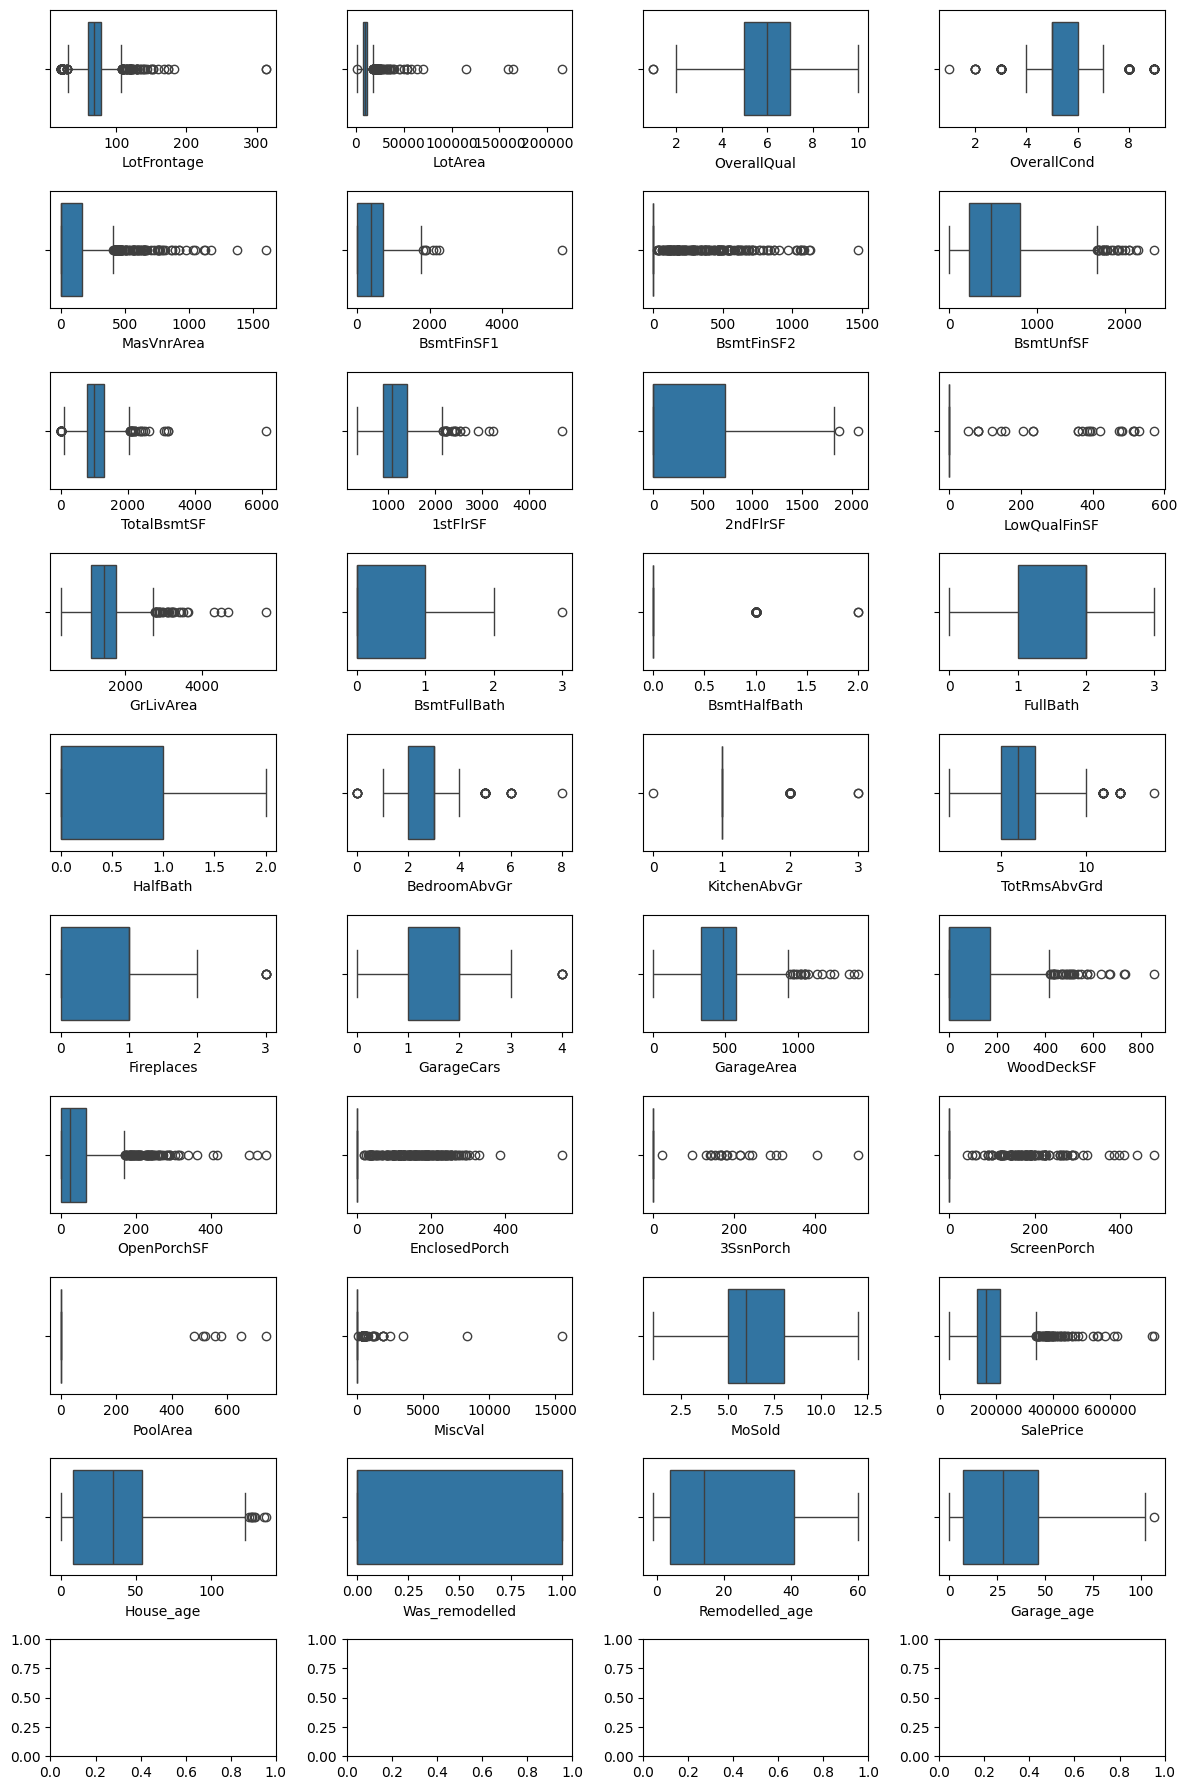

In [13]:
#box plot and outliers
fig, axes = plt.subplots(10,4, figsize = (12,18))
axes = axes.flatten()
for idx, feature in enumerate(num_df.columns):
    axes[idx] = sns.boxplot(x= data_exp[feature], ax= axes[idx])

plt.tight_layout()
plt.show()

Some outliers are strongly detached from the rest. Consider removal. Let's inspect better by looking at spread between max and 99 percentile

In [14]:
# Check which features show a gap between max value and 99-percentile value
data_exp.describe(percentiles=[0.90, 0.95, 0.99])

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,House_age,Was_remodelled,Remodelled_age,Garage_age
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,69.861454,10518.951303,6.097394,5.574760,103.258573,443.600137,46.613169,566.534979,1056.748285,1162.089849,347.468450,5.852538,1515.410837,0.425240,0.057613,1.564472,0.383402,2.866941,1.046639,6.517147,0.613169,1.766118,472.585734,94.277778,46.685871,21.984225,3.414266,15.081619,2.762689,43.548697,6.319616,180730.190672,36.598080,0.477366,22.981481,29.273663
std,22.038589,9987.895073,1.382847,1.113452,180.814962,456.073916,161.420729,441.185107,438.591599,386.548397,436.638462,48.655960,525.815190,0.518929,0.238907,0.551058,0.503030,0.816014,0.220483,1.626410,0.644829,0.747104,213.565518,125.394752,66.289760,61.155666,29.337173,55.792877,40.204743,496.460799,2.703751,79284.550497,30.240565,0.499659,20.637282,24.024607
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
50%,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.000000,1086.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,479.500000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,35.000000,0.000000,14.000000,28.000000
90%,92.000000,14395.100000,8.000000,7.000000,335.000000,1066.500000,117.600000,1229.200000,1602.000000,1680.000000,954.600000,0.000000,2158.900000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,9.000000,1.000000,3.000000,756.300000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,277650.000000,84.000000,1.000000,56.000000,61.000000
95%,104.000000,17403.450000,8.000000,8.000000,456.000000,1274.000000,396.600000,1460.350000,1753.000000,1831.750000,1141.150000,0.000000,2466.300000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000,10.000000,2.000000,3.000000,846.600000,335.000000,175.150000,180.450000,0.000000,160.000000,0.000000,0.000000,11.000000,325680.400000,91.000000,1.000000,58.000000,78.000000
99%,137.430000,37619.720000,10.000000,9.000000,791.440000,1572.430000,830.740000,1797.150000,2155.150000,2219.580000,1419.160000,360.000000,3124.040000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,11.000000,2.000000,3.000000,1003.170000,505.580000,285.860000,261.150000,168.000000,268.150000,0.000000,700.000000,12.000000,442692.230000,110.430000,1.000000,60.000000,90.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,136.000000,1.000000,60.000000,107.000000


Focusing on continous data, some features show a gap between max and 99 percentile, especially LotFrontage, LotArea, BsmtFinSF1, TotalBsmtSF, MiscVal. Let's check the top 20 values for them. 


In [15]:
#Check top 20 values
possible_outliers = [ "LotArea", "BsmtFinSF1", "TotalBsmtSF", "MiscVal"]
outliers_dict = {}

for feat in possible_outliers:
    sorted_values = data_exp[feat].sort_values(ascending= False)
    #reset index and drop, to allow concatenating all series in one df
    outliers_dict[feat] = sorted_values.reset_index(drop= True).values

outlier_df = pd.DataFrame(outliers_dict)
outlier_df.head(20)

#miscval and LotArea are the weirdest, and possibly BsmtFinSF1, TotalBsmtSF

,LotArea,BsmtFinSF1,TotalBsmtSF,MiscVal
0,215245,5644,6110,15500
1,164660,2260,3206,8300
2,159000,2188,3200,3500
3,115149,2096,3138,2500
4,70761,1904,3094,2000
5,63887,1880,2633,2000
6,57200,1810,2524,2000
7,53504,1767,2444,2000
8,53227,1721,2396,1400
9,53107,1696,2392,1300


The 1st-ranked is clearly separated from the rest for these 4 features. Let's check if it's aberrant. 

In [16]:
features_of_interest = ["LotArea",	"BsmtFinSF1",	"TotalBsmtSF",	"MiscVal"]
top_house_dict = {}

for feat in features_of_interest :
    max_idx = data_exp[feat].idxmax()
    #retrive the feature values for the house with the max value for the feature on interest
    top_house_dict[f"{feat}_max"] = data_exp.loc[max_idx]

top_house_df = pd.DataFrame(top_house_dict)
top_house_df

,LotArea_max,BsmtFinSF1_max,TotalBsmtSF_max,MiscVal_max
MSSubClass,20,60,60,20
MSZoning,RL,RL,RL,RL
LotFrontage,150.0,313.0,313.0,69.0
LotArea,215245,63887,63887,12772
Street,Pave,Pave,Pave,Pave
Alley,None,None,None,None
LotShape,IR3,IR3,IR3,IR1
LandContour,Low,Bnk,Bnk,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,Corner,Corner,CulDSac


- LotArea max: seems ok: just a large terrain with a smaller house. 
- Bsmt features: a bit weird: sale price at the median, while it has a pool. 2nd floor SF much smaller than 1st floor, and basement even larger. Overall quality 10, apparently new (house age = 0). Doesnt really make sense with the house price. let's remove. 
- MiscVal: logical because it has a second garage. 

In [17]:
# REMOVAL ABERRANT HOUSE
#check that we have just one house in this condition
(data_exp["TotalBsmtSF"] == 6110).sum()
#drop it
data_exp = data_exp[data_exp["TotalBsmtSF"] != 6110]

### Inspect skewness and transform

#### Distribution

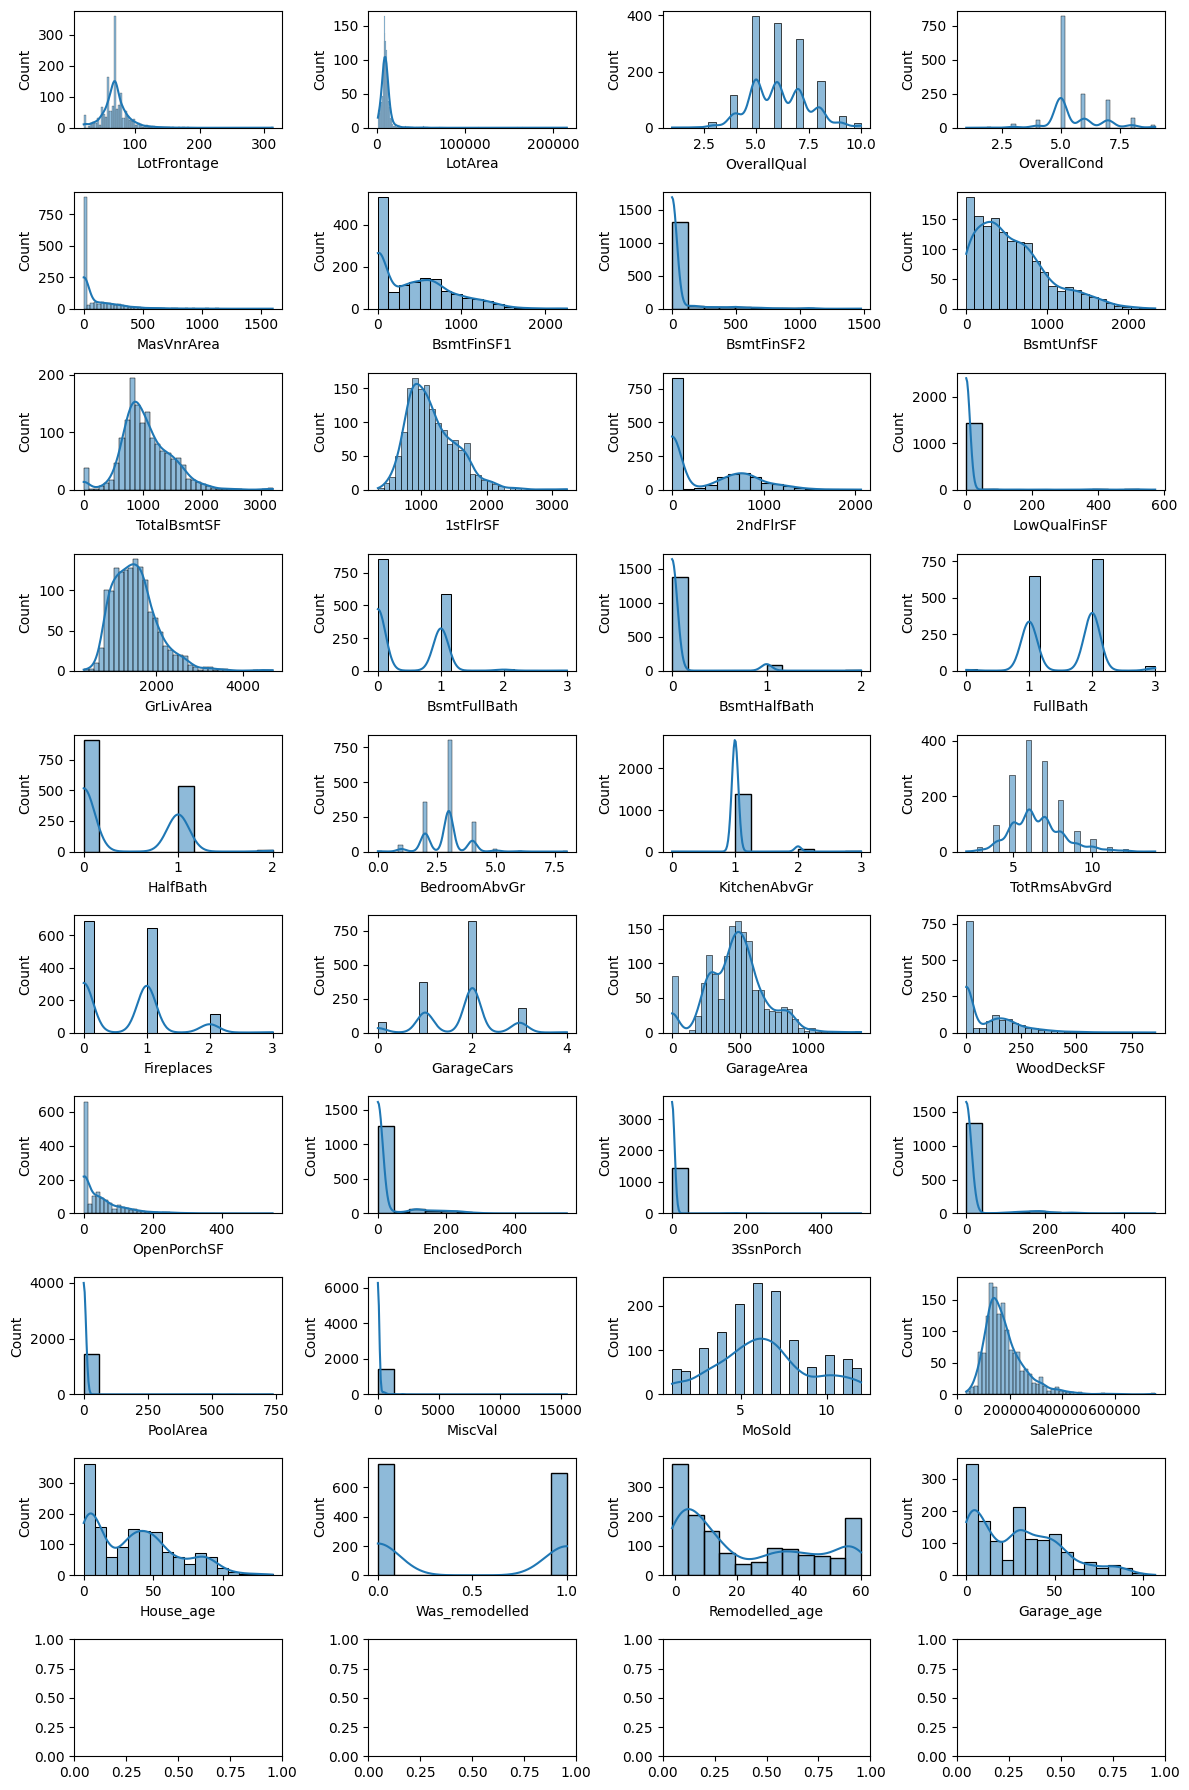

In [18]:
#distribution

fig, axes = plt.subplots(10,4, figsize = (12,18))
axes = axes.flatten()
for idx, feature in enumerate(num_df.columns):
    axes[idx] = sns.histplot(x= data_exp[feature], kde= True, ax= axes[idx])

plt.tight_layout()
plt.show()

#### Skewness

- Help to decide on the necessity of feature transformation (log). 
- we'll use usual threshold: transformation if skewness above 1.5, and consider transformation for skewness between 0.5 and 1. 


In [19]:
skewness = data_exp[num_df.columns].skew().sort_values(ascending= False)


#### Log Transformation

**Objective:** Reduce skewness in numerical features to improve model performance, particularly for linear models.

**Methodology:**
1. Selection criteria: Apply log transformation to features with `|skewness| ≥ 1.5`
   - Threshold rationale: Global compromise suitable for both linear models (Ridge, Lasso, LinearReg) and tree-based models (XGBoost, RandomForest, CatBoost)
   - Features with `|skewness| < 1.5` are considered sufficiently symmetric

2. **Exclusions from transformation:**
   - Discrete/count features: (e.g., `KitchenAbvGr`, `BsmtHalfBath`) → Log transformation inappropriate for discrete values; will be handled with MinMaxScaler to preserve sparsity and distance
   - Target variable: (`SalePrice`) → Will be handled separately with dedicated strategy

3. **Transformation method:** `np.log1p()` (log(1 + x))
   - Handles zeros: `log1p(0) = 0`
 



In [20]:

to_log_transform = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'WoodDeckSF']

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'SalePrice',
       'LotFrontage', 'WoodDeckSF'],
      dtype='object')


In [21]:
#log transformed
log_transformed = np.log1p(data_exp[to_log_transform])
log_transformed

#visualisation de l'effet
pd.DataFrame(data= {"before": skewness[skewness > 1.5], "after": log_transformed.skew(), "reduction" : (skewness[skewness > 1.5] -log_transformed.skew()) / skewness[skewness > 1.5] * 100 })


,before,after,reduction
3SsnPorch,10.293487,7.726645,24.936562
BsmtFinSF2,4.250256,2.519985,40.709803
BsmtHalfBath,4.098469,NaN,NaN
EnclosedPorch,3.085809,2.108812,31.660972
KitchenAbvGr,4.483125,NaN,NaN
LotArea,12.466190,-0.169089,101.356384
LotFrontage,1.717319,-0.962569,156.050672
LowQualFinSF,9.001760,7.452254,17.213367
MasVnrArea,2.684238,0.502631,81.274736
MiscVal,24.451726,5.164816,78.877499


#### Conclusion on Log Transformation

**Observations:**

1. **Successful transformations:** Several features achieved significant skewness reduction 
   - These features had right-skewed continuous distributions that responded well to log compression

2. **Limited effectiveness:** Some features showed < 50% skewness reduction (e.g., `PoolArea`: 15.94 → 15.51, `3SsnPorch`: 10.29 → 7.73, `LowQualFinSF`: 9.00 → 7.45)
   
3. **Cause: Zero-inflated distributions:**
   - Many features exhibit bimodal distributions: large proportion of zeros (absence of characteristic) + normal distribution for non-zero values
   - Example: `PoolArea` → ~99% of houses have 0 (no pool), remaining ~1% have normally distributed pool areas
   - Log transformation reduces skewness within the non-zero values but *cannot resolve the bimodality* caused by the spike at zero
   - The transformed distribution remains bimodal

**Possible next steps:**
- For zero-inflated features (especially those without categorical counterparts like `OpenPorchSF`, `3SsnPorch`):
  - **Decomposition strategy:** Create two separate features:
    1. Binary feature: `Has_Feature` (0/1) → captures the *presence effect*
    2. Continuous feature: `Feature_log1p` → captures the *magnitude effect* (when present)
  
**Decision for now:** Keep log-transformed features as-is for modeling pipeline. Evaluate performance and revisit decomposition strategy in feature engineering if needed. 

### Distribution and scaling

- Distribution histgram already presented earlier
- Discrete features will usually be scaled using minmax to preserve sparsity and distances between values. They won't be log transformed. 
- Clearly binary won't be scaled (already encoded)
- non-normal distribution and/or presence of outliers will be robust scaled

In [22]:


to_minmax = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "FullBath",'HalfBath',
             "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]
#MoSold is discrete but is cyclical, should be handled separately to transform in cosinus and sinuswhich will inherently scale it

to_robust = [col for col in num_df.columns if col not in to_minmax]
#remove binary features (ex: Has garage) and the target and the cyclical feature
to_robust = [col for col in to_robust if col not in ["Was_remodelled", "Has_garage", "SalePrice", 'MoSold']]

In [23]:
to_robust

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'House_age',
 'Remodelled_age',
 'Garage_age']

In [24]:
assert len(to_minmax) + len(to_robust) + 3 == len(num_df.columns)

#### Handling cyclical feature


In [25]:
#to be implemented in the pipeline
# data_exp["cos_MoSold"] = np.cos(2* np.pi * (data_exp["MoSold"] - 1)/12)
# data_exp["sin_MoSold"] = np.sin(2* np.pi * (data_exp["MoSold"] - 1)/12)
# data_exp = data_exp.drop(columns="MoSold")
# data_exp.head(2)

## I.5 Inspect Categorical Features

- cardinality/ordinality
- proportion

### Check the ordinality
- ordinal features based on documentation
- quality/condition ordinality will map "None" to 0 bc we assume than not having the characteristic is worse than having a poor one. 

In [26]:
to_ordinal = [
    'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'HeatingQC', 'KitchenQual',
    'FireplaceQu',
    'GarageQual', 'GarageCond', 'GarageFinish',
    'PoolQC',
    'LotShape', 'LandSlope'
]
ordinal_mapping = {
            # Quality features (conditional)
            'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
            'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
            'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},

            # Quality features (always present)
            'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

            # Other ordinals
            'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
            'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3}
        }

### Check the Cardinality
- Check the cardinality of features that are NOT to be ordinally encoded. 
- list the high cardinality features (>15) to target encode
- list for one hot encoding the others. 


In [27]:
#check cardinality of remaining features
not_ordinal = [col for col in cat_df.columns if col not in to_ordinal]
cardinal_df = cat_df[not_ordinal]
cardinality = cardinal_df.nunique().sort_values(ascending= False)
#select columns with low cardinality to one hot encode.
low_cardinality_col = cardinality[cardinality < 10].index.tolist()
#select high cardinality columns for target encoding
high_cardinality_col = [col for col in cardinal_df.columns if col not in low_cardinality_col]


In [28]:
#explore rare values among low cardinality columns
#count how many rare values, considering a rare value is present less than 2%
total_rare_values = 0
features_saved = 0

for col in low_cardinality_col:
    rare_values =(cardinal_df[col].value_counts(normalize= True) < 0.02).sum()
    print(f"There are {rare_values} rare values in {col}")
    total_rare_values += rare_values

    # If we group R rare values into "Other", we save R-1 features
    if rare_values > 0:
        features_saved += (rare_values - 1)

print(f"\nTotal rare values across all columns: {total_rare_values}")
print(f"By grouping rare categories into 'Other', we could reduce OneHot features by: {features_saved}")

There are 6 rare values in SaleType
There are 6 rare values in Condition1
There are 7 rare values in Condition2
There are 3 rare values in HouseStyle
There are 7 rare values in RoofMatl
There are 4 rare values in Functional
There are 3 rare values in Foundation
There are 0 rare values in BsmtFinType1
There are 3 rare values in GarageType
There are 5 rare values in Heating
There are 2 rare values in BsmtFinType2
There are 3 rare values in SaleCondition
There are 4 rare values in RoofStyle
There are 2 rare values in MSZoning
There are 3 rare values in Electrical
There are 0 rare values in BldgType
There are 1 rare values in LotConfig
There are 0 rare values in Fence
There are 1 rare values in MiscFeature
There are 0 rare values in LandContour
There are 0 rare values in MasVnrType
There are 0 rare values in PavedDrive
There are 1 rare values in Utilities
There are 1 rare values in Street
There are 0 rare values in CentralAir
There are 0 rare values in Alley

Total rare values across all c

### Conclusion: Cardinality Analysis & Encoding Strategy

Based on the cardinality analysis of our categorical features, we have established the following encoding strategy:

**1. Ordinal Encoding** for features with natural order 

**2. Low Cardinality Features (< 10 unique values)**

- **Encoding:** OneHot Encoding with risk of explosion of dimensionality, so we'll group rare categories.
- **Rare category handling:** 
  - Threshold: < 2% frequency
  - **Total rare values identified:** 62 across all low-cardinality features
  - **Strategy:** Group rare categories into "Other" before OneHot encoding. Should reduce the total number of features.

**3. High Cardinality Features (> 10 unique values)**
- **Count:** Features like Neighborhood (25 values), Exterior1st (15 values)
- **Encoding:** Target Encoding
- **Rationale:** 
  - Avoids explosion of features (1 column per feature vs. N columns with OneHot)
  - Captures relationship with target directly
  - Handles rare categories through regularization (smoothing)
  - Use the target encoder transformer for sklearn to use smoothing and crossfit. 


## I.6 Features vs target. 

### Ordering numerical features according to correlation with target

In [29]:
 # correlation matrix
corr_matrix = num_df.corr()
target_corr = corr_matrix["SalePrice"]
target_corr_sorted = target_corr.abs().sort_values(ascending= False)
target_corr_sorted = target_corr_sorted.drop("SalePrice")

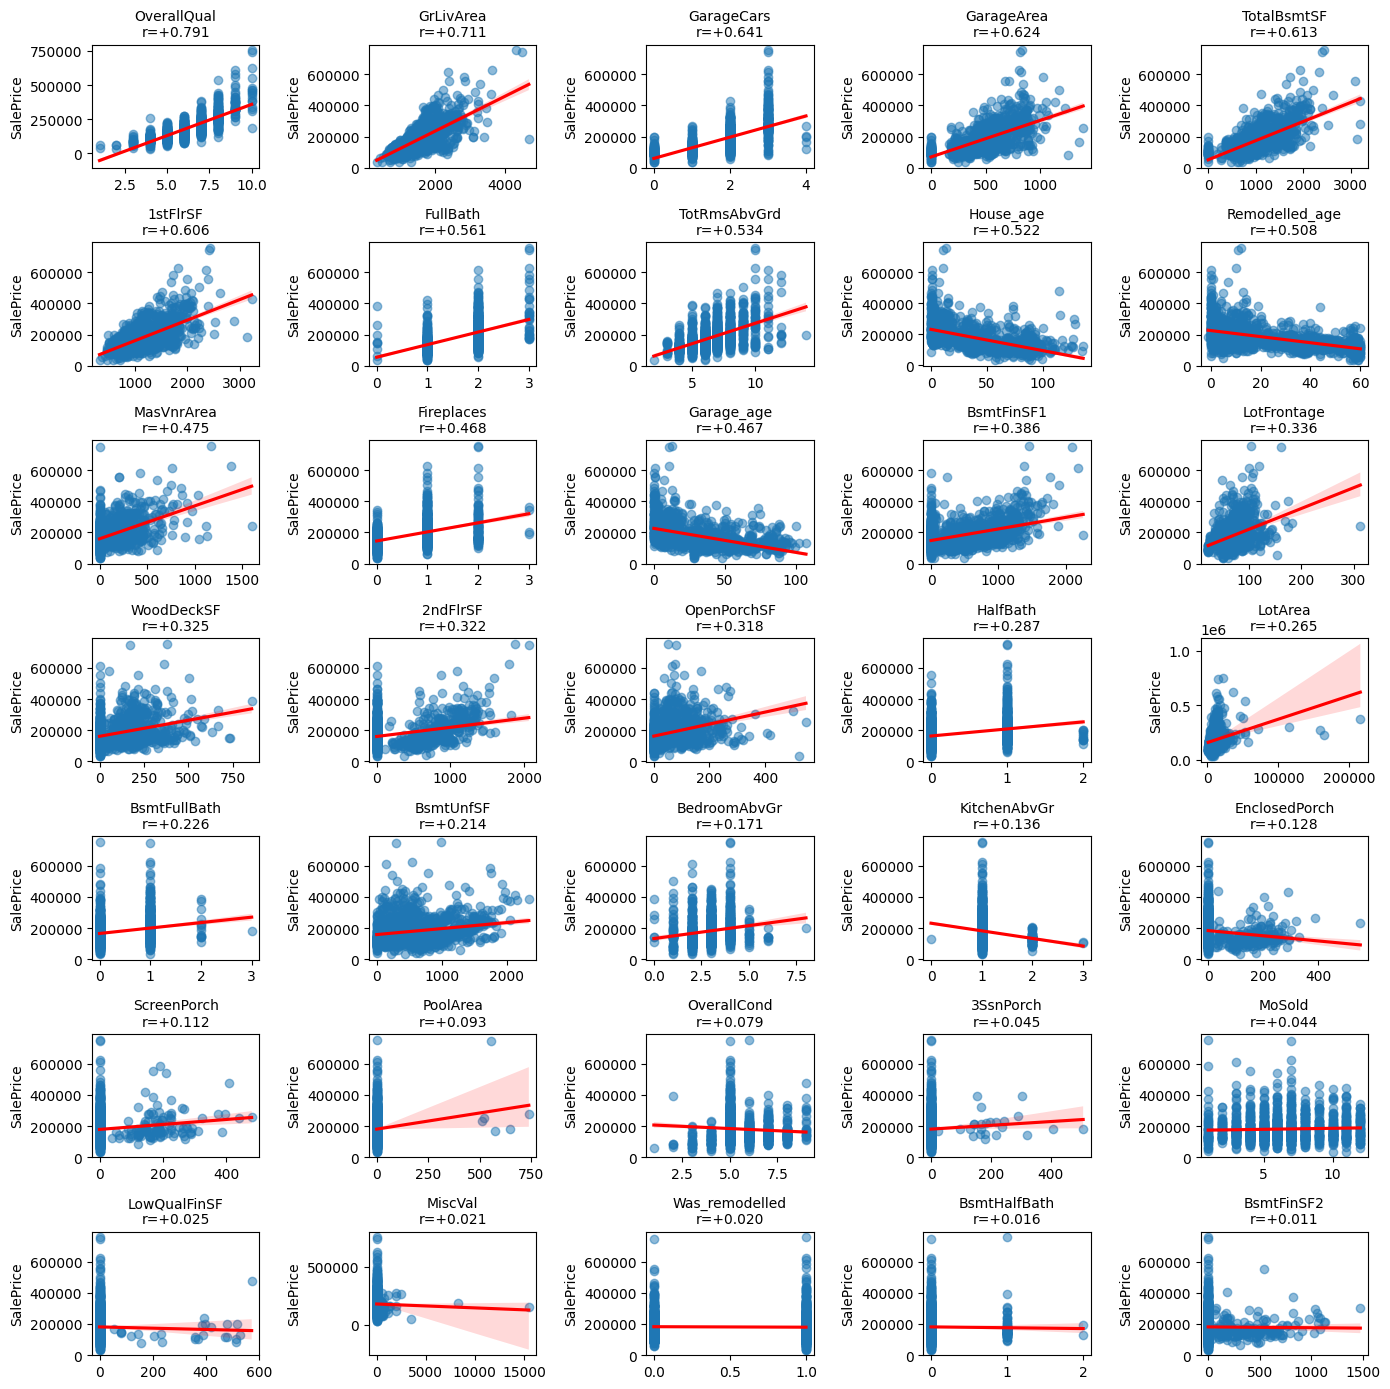

In [30]:
# representation of target as function of feature
fig, axes = plt.subplots(7, 5, figsize= (14,14))
axes = axes.flatten()
for idx, feature in enumerate(target_corr_sorted.index):
    corr_value = target_corr_sorted[feature]
    sns.regplot(x= data_exp[feature], y= data_exp["SalePrice"], ax=axes[idx], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    axes[idx].set_title(f"{feature}\nr={corr_value:+.3f}", fontsize=10)
    axes[idx].set_xlabel("")
plt.tight_layout()


#### Conclusion on relationship between numerical features and target

- Numerical features exhibit **both positive and negative correlations** with SalePrice, with most showing clear directional relationships.
- **Strong positive associations:** OverallQual (r=+0.791), GrLivArea (r=+0.709), GarageCars/GarageArea, TotalBsmtSF — larger/better quality features consistently predict higher prices, though some display **non-linear patterns** (OverallQual shows accelerating returns, with steeper price increases at higher quality levels).
- **Moderate associations:** YearBuilt, YearRemodAdd, FullBath — positive trends with considerable scatter, suggesting these contribute but are not deterministic alone.
- **Weak or absent associations:** LowQualFinSF, BsmtHalfBath, EnclosedPorch, 3SsnPorch (r≈0) — minimal predictive power, likely candidates for removal or transformation.
- **Interesting patterns:** LotFrontage and LotArea show **bimodal or segmented patterns** suggesting possible interaction effects with other features (e.g., location or zoning) — these may benefit from feature engineering (binning or interaction terms).
- **Linearity:** While most relationships appear reasonably linear (justifying log transformations for skewed features), several (OverallQual, YearBuilt) show **slight curvature** that tree-based models will capture better than linear models.


### How cardinal features impact Sale Price

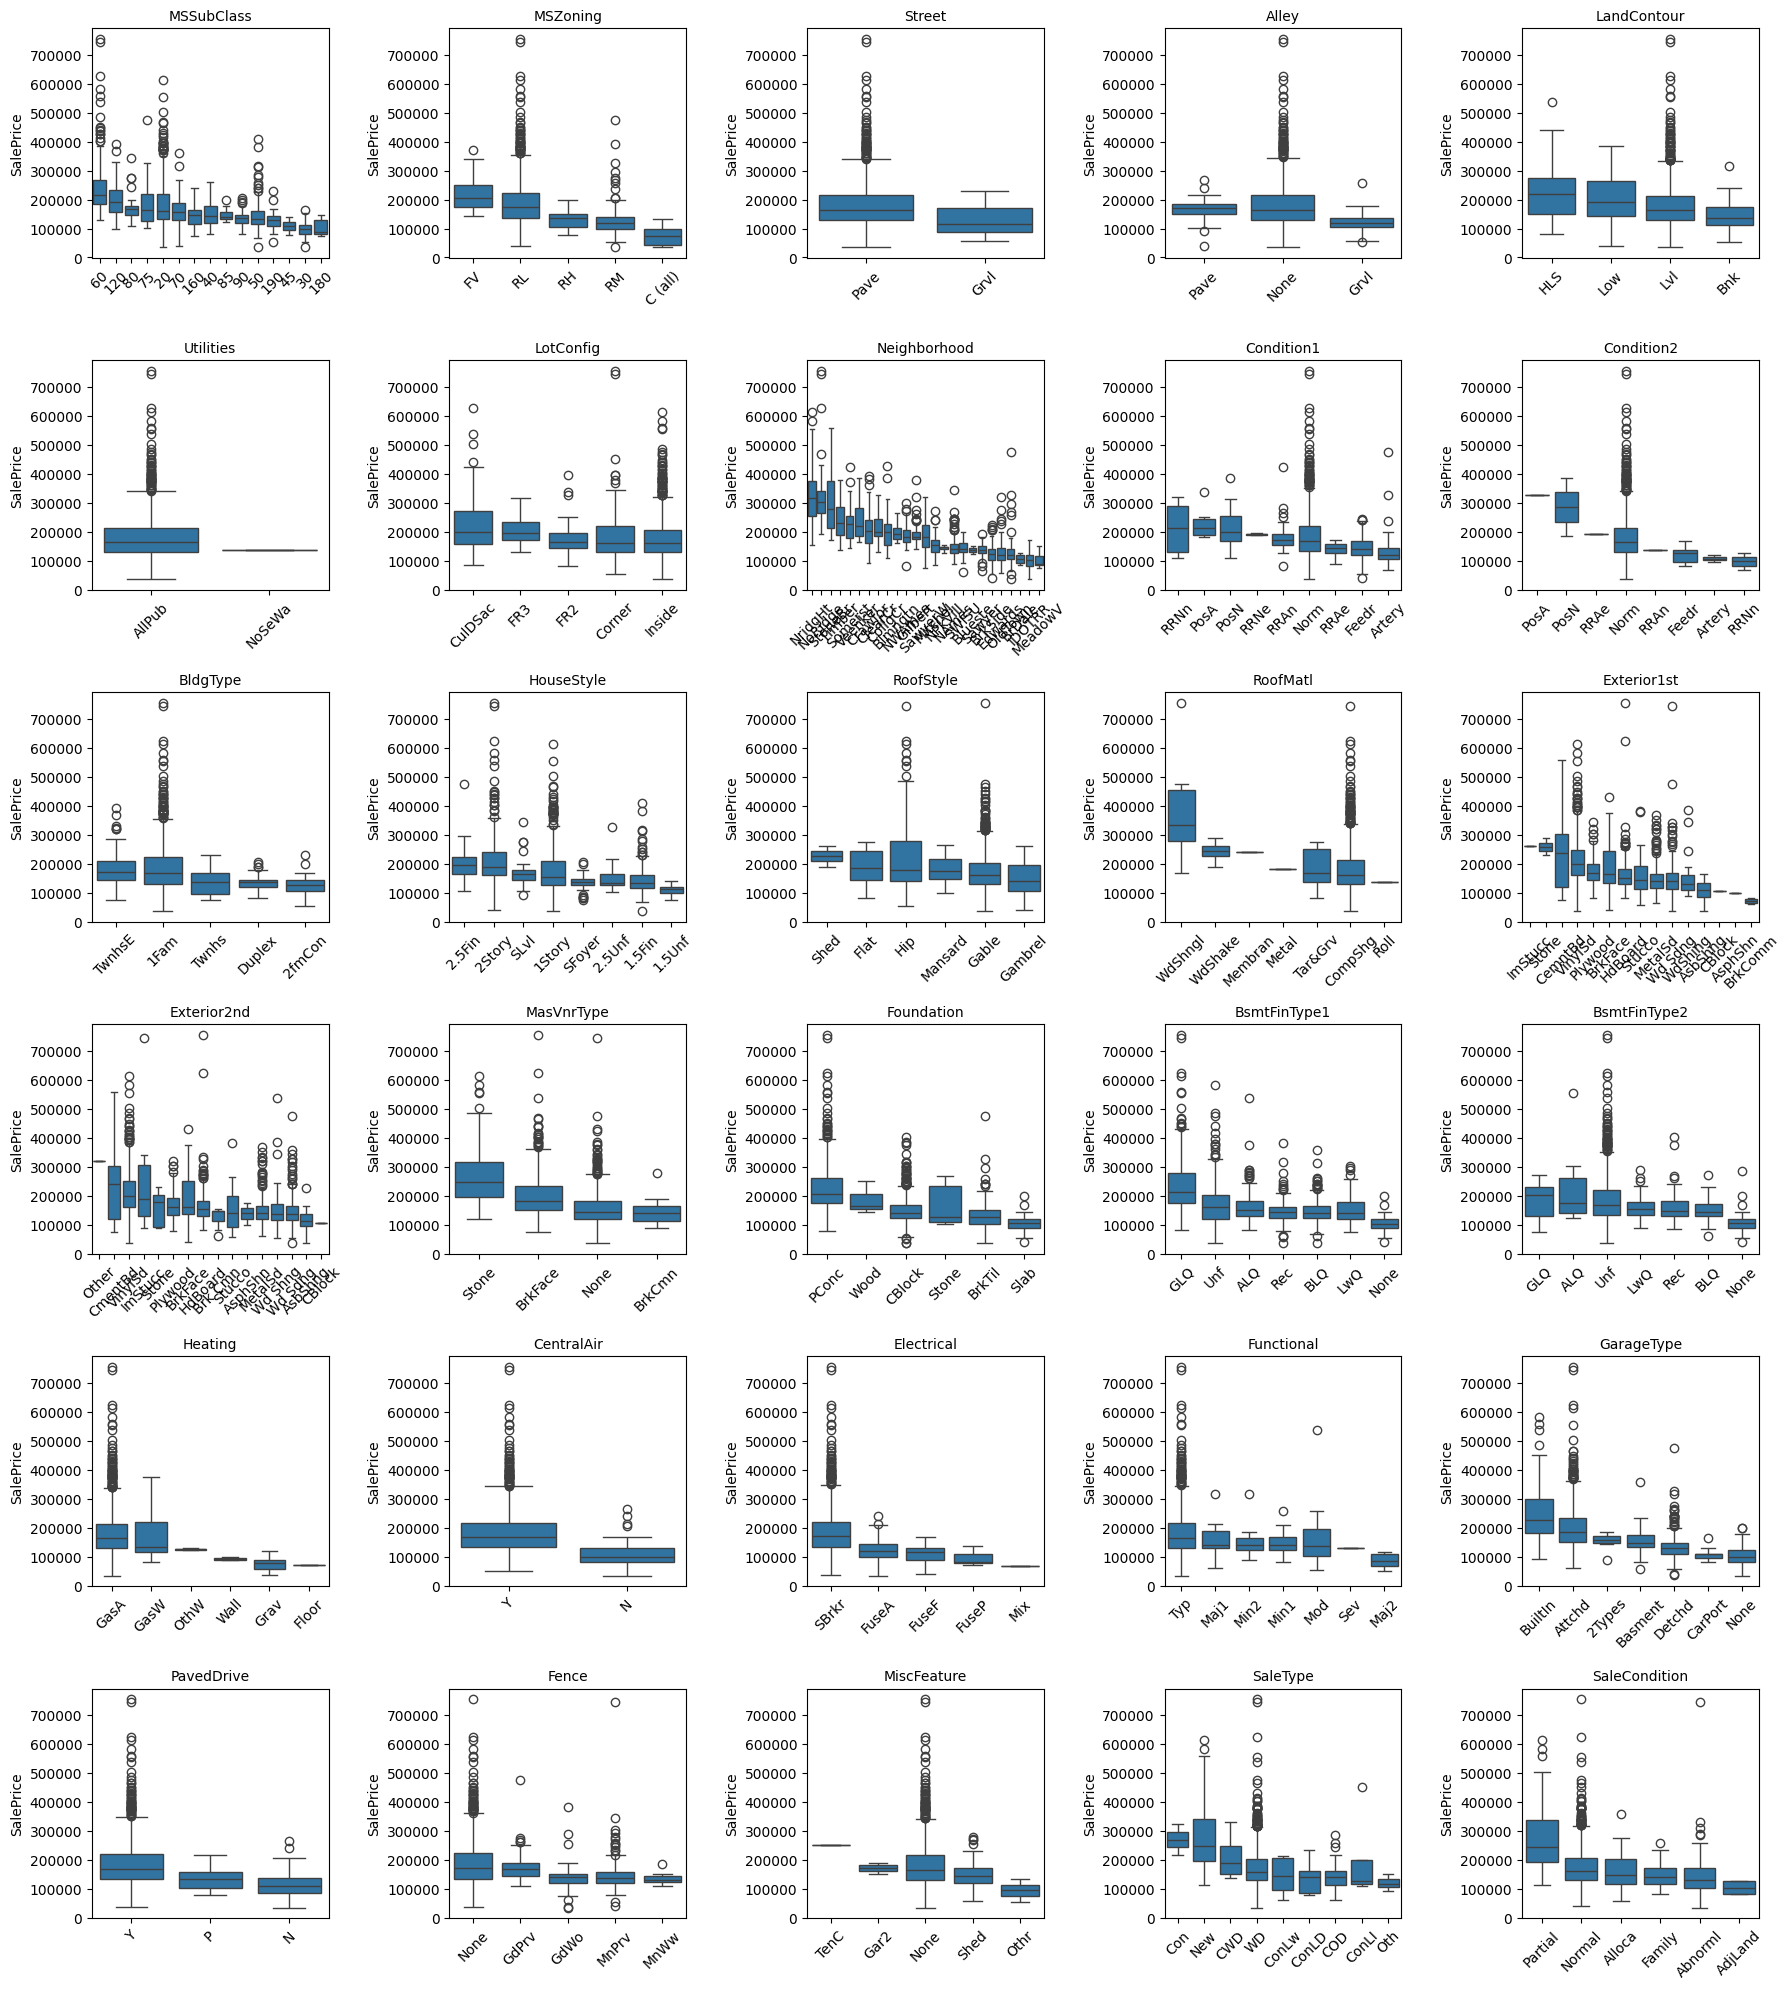

In [31]:
fig, axes = plt.subplots(6,5, figsize=(18,20))
axes = axes.flatten()
for idx, feature in enumerate(cardinal_df.columns):
    median_order = (data_exp.groupby(feature)['SalePrice']
                    .median()
                    .sort_values(ascending=False)
                    .index
                    .tolist())
    sns.boxplot(x= data_exp[feature], y= data_exp["SalePrice"], ax=axes[idx], order=median_order)
    axes[idx].set_title(f"{feature}", fontsize= 10)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()


#### Conclusion on relationship between cardinal categorical features and target
- Nominal categorical features show **varying degrees of association** with SalePrice, though most exhibit considerable within-category variability.
- **Strongest associations:** Neighborhood, MSZoning, MasVnrType, SaleType, SaleCondition — clear differences in median price across categories, suggesting these capture important market segments.
- **Weaker or negligible impact:** Fence, RoofStyle, Alley, Utilities — minimal price differentiation between categories, likely candidates for feature selection filtering.
- **Key insight:** High-cardinality features (Neighborhood, Exterior types) will benefit from target encoding to capture price signals while avoiding dimensionality explosion.
- **Variability:** Even strong features show significant overlap between categories, indicating that price is determined by multiple factors acting in combination rather than single categorical features alone. 

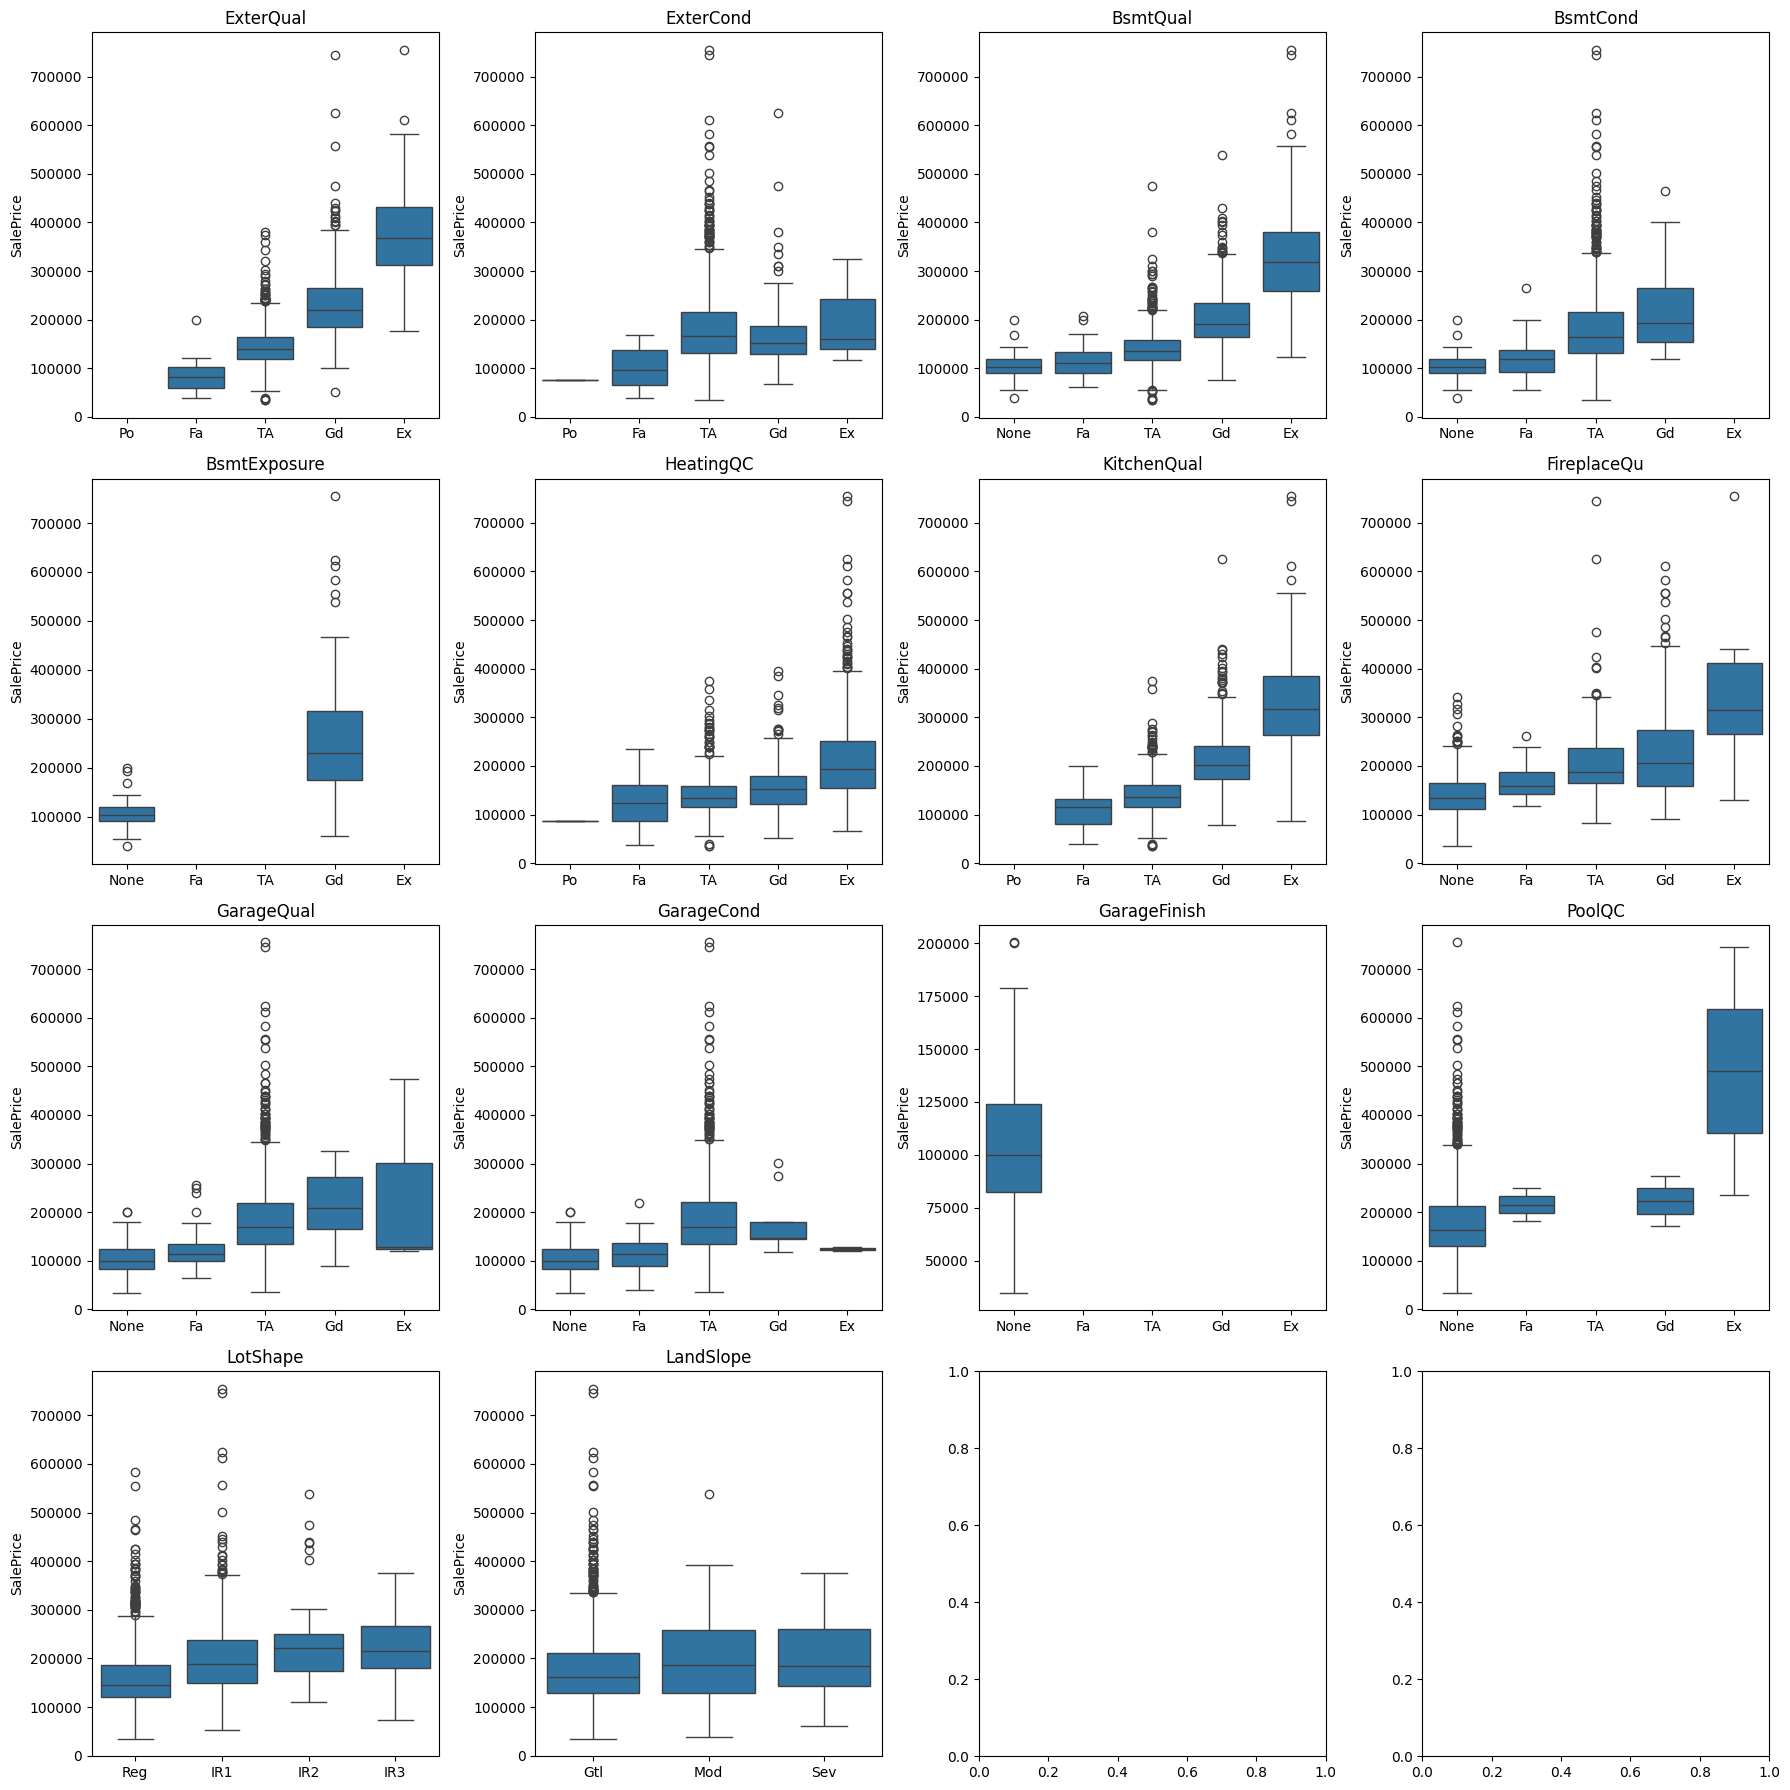

In [32]:
fig, axes = plt.subplots(4,4, figsize=(18,18))

axes = axes.flatten()
for idx, feature in enumerate(to_ordinal):

    if feature in ['ExterQual','KitchenQual', 'ExterCond', 'HeatingQC']:
        order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

    elif feature in ['BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'GarageQual',
            'GarageCond',
            'GarageFinish',
            'FireplaceQu',
            'PoolQC']:
        order= ['None', 'Fa', 'TA', 'Gd', 'Ex']

    else:
        order= None

    sns.boxplot(x= data_exp[feature], y= data_exp["SalePrice"], ax = axes[idx], order= order)
    axes[idx].set_title(f"{feature}")
    axes[idx].set_xlabel("")

plt.tight_layout()


#### Conclusion on relationship between ordinal categorical features and target
- Unsurprisingly, ordinal quality/condition features show **strong monotonic relationships** with SalePrice: higher quality → higher price across the board.
- **Strongest associations:** OverallQual, KitchenQual, ExterQual, BsmtQual — clear step-wise increase in median price with each quality level.
- **Weaker but consistent:** GarageCond, HeatingQC, BsmtCond — pattern is visible but with more variability and overlap between adjacent categories.
- **Key insight:** The ordinal encoding will be highly beneficial as it preserves this natural ordering that models can exploit.
- **Outliers:** Some lower-quality categories still have high-price outliers, suggesting other features (location, size) can compensate for quality deficiencies. 

# II. Preprocessing pipeline

## II.1 Pipeline Design

*Note: This pipeline doesn't yet include advanced transformations like log transform, cyclical encoding, or zero-inflation decomposition*

### Pre-preprocessing: to be done outside of pipeline
- Drop aberrant row (TotalBsmtSF = 6110) from train set
- Drop rows with illogical MasVnrType/Area combinations (Area=0 but Type≠NA)

### Pipeline Steps 

**1. MSSubClass dtype conversion**
   - Convert to string (categorical feature misencoded as numeric)
   - Tool: `FunctionTransformer` (stateless)

**2. "NA means absence" imputation**
   - Impute NA → "None" for `col_to_impute_na` (categorical features where NA indicates absence per documentation)
   - Tool: `SimpleImputer(strategy="constant", fill_value="None")`

**3. MasVnrType & MasVnrArea conditional imputation**
   - Handl different configurations with conditional logic
   - Tool: Custom Transformer (stateful: learns mode/median during fit)

**4. LotFrontage imputation**
   - Impute missing values with median
   - Tool: `SimpleImputer(strategy="median")`

**5. Electrical imputation**
   - Impute missing values with mode
   - Tool: `SimpleImputer(strategy="most_frequent")`

**6. Year features → Age features**
   - Sub-pipeline with 3 steps:
     1. Engineer age features from year features (House_age, Remodelled_age, Garage_age) → `FunctionTransformer` (stateless)
     2. Impute Garage_age with median `SimpleImputer`
     3. Drop original year columns → `FunctionTransformer` (stateless)

**7. Ordinal encoding**
   - Encode ordinal categorical features with predetermined mappings
   - Tool: `OrdinalEncoder(categories=[...])`

**8. Low cardinality categorical encoding**
   - Group rare categories (learned during fit) → Custom Transformer (stateful)
   - One-Hot encode → `OneHotEncoder`

**9. High cardinality categorical encoding**
   - Target encode using y during fit
   - Tool: `TargetEncoder`

**10. Numerical scaling**
   - Apply scalers to predetermined feature groups (RobustScaler, MinMaxScaler, StandardScaler)
   - Tool: `ColumnTransformer` with multiple scalers



## II.2 preparing custom transformers and function transformers

In [33]:
# MSSubClass dtype change
# Using FunctionTransformer on entire DataFrame to preserve column names
# ColumnTransformer with remainder="passthrough" would rename columns (e.g., "remainder__LotFrontage")
def dtype_changer_func(X):
    """Convert MSSubClass to string, preserving all other columns and their names"""
    X = X.copy()
    X["MSSubClass"] = X["MSSubClass"].astype(str)
    return X

dtype_changer = FunctionTransformer(dtype_changer_func)


In [34]:
#=====================================
#MasVnrType and MasVnrArea transformer
#=====================================

from sklearn.base import BaseEstimator, TransformerMixin

class VeneerImputer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    # learn Type mode and area median
    def fit(self, X, y= None):

        self.area_median_ = X["MasVnrArea"].median()
        self.type_mode_ = X["MasVnrType"].mode()[0]
        return self

    #conditional treatment depending on row values

    def transform(self, X, y= None):
        X = X.copy()
        # When Area = 0 and Type = NA: absence
        X.loc[(X["MasVnrArea"] == 0) & X["MasVnrType"].isna(), "MasVnrType"] = "None"

        #When Area > 0, Type = NA: missing entry
        X.loc[(X["MasVnrArea"] > 0) & X["MasVnrType"].isna(), "MasVnrType"] = self.type_mode_

        #Whean Area is NA and Type is NA: missing entry
        fill_values = {"MasVnrArea": self.area_median_, "MasVnrType" : self.type_mode_}
        X[["MasVnrArea","MasVnrType" ]] = X[["MasVnrArea","MasVnrType" ]].fillna(fill_values)

        return X


In [35]:

#=====================================
# Years features engineering and imputing
#=====================================

# step1 generating "age" features
def age_calculator(X):
    """ calculate age by calculating difference of two columns"""
    X = X.copy()
    X["House_age"] = X["YrSold"] - X["YearBuilt"]
    X["Was_remodelled"] = (X["YearRemodAdd"] != X["YearBuilt"]).astype(int)
    X["Remodelled_age"] = X["YrSold"] - X["YearRemodAdd"]
    X["Garage_age"] = X["YrSold"] - X["GarageYrBlt"]

    return X

age_generator = FunctionTransformer(age_calculator)

#step 2 imputing NA (theoretically only Garage_age is concerned but we can apply to all)
age_imputer = make_column_transformer(
    (SimpleImputer(strategy="median"), ["Garage_age"]),
    remainder="passthrough",  # Leave other columns unchanged
    verbose_feature_names_out=False  # Prevent column renaming (e.g., "remainder__LotFrontage")
)

#step 3 : drop years column
years_dropper = FunctionTransformer(lambda x: x.drop(columns= ["GarageYrBlt", "YrSold","YearBuilt", "YearRemodAdd"]))

age_transformer = make_pipeline(age_generator, age_imputer, years_dropper)

In [36]:

#===============================================
#rare values grouper in low cardinality features
#===============================================

class RareValuesGrouper(BaseEstimator, TransformerMixin):

    """ X: dataframe of LOW CARDINALITY columns.
    This means that separation between high cardinality and low card. should be down before pipeline"""
    def __init__(self, threshold= 0.02):
        self.threshold = threshold #threshold of frequency below which a value is deemed "rare". Default= 2%

    def rare_value_mask(self, X, col):

        val_count = X[col].value_counts(normalize = True)
        return val_count[val_count < self.threshold].index.tolist()


    #count and identify rare values
    def fit(self,X, y= None):
        # Walrus operator (:=) used here: assigns rare_vals AND uses it in the condition
        # Avoids calling rare_value_mask() twice (once for value, once for condition)
        # Only includes columns that have rare values (non-empty list is truthy)
        self.rare_values_ = {col : rare_vals for col in X.columns if (rare_vals := self.rare_value_mask(X, col))}
        return self

    # replace all rare values by "Other"
    def transform(self, X, y= None):
        X = X.copy()
        # For each column with rare values, replace them with "Other"
        for col in self.rare_values_.keys():
            X[col] = X[col].replace(self.rare_values_[col], "Other")
        return X


In [37]:
#===============================================
# General feature engineering
#===============================================

class FeatureEngineer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y= None):
        return self


    def transform(self, X, y= None):
        X = X.copy()
        X["TotalSF"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
        X["OverallQual_GrLivArea"] = X["OverallQual"] * X["GrLivArea"]
        X["TotalBath"] = X["FullBath"] + 0.5*X["HalfBath"] + X["BsmtFullBath"] + 0.5 * X["BsmtHalfBath"]
        X["TotalPorch"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
        X["QualityScore"] = X["OverallQual"] + X["OverallCond"]
        X["TotalSFperRoom"] = X["TotalSF"] / (X["TotRmsAbvGrd"] + 1) #to avoid div by zero

        #Binary values to ease split on presence/absence
        X["Has_Bsmt"] = (X["TotalBsmtSF"] > 0).astype(int)
        X["Has2ndFloor"] = (X["2ndFlrSF"] > 0).astype(int)
        X["HasGarage"] = (X["GarageArea"] > 0).astype(int)
        X["HasFireplace"] = (X["Fireplaces"] > 0).astype(int)

        return X

engineered_to_minmax = ["TotalBath", "TotalPorch","QualityScore" ]
engineered_to_robust = ["TotalSF", "OverallQual_GrLivArea","TotalSFperRoom"]
engineered_binary = ["Has_Bsmt", "Has2ndFloor","HasGarage", "HasFireplace" ] #should be removed from to_robust (no need to scale)


## II.3 Elaboration pipeline

### Column lists

##### Imputing and scaling

In [38]:
col_to_impute_na = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                    "Fence", "MiscFeature"]

year_features = ["GarageYrBlt", "YrSold","YearBuilt", "YearRemodAdd"]


##### Ordinal encoding

In [39]:

ordinal_mapping = {
            # Quality features (conditional)
            'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
            'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'GarageCond':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
            'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],

            # Quality features (always present)
            'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],

            # Other ordinals
            'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
            'LandSlope': ['Sev', 'Mod', 'Gtl']
        }


ordinal_features = list(ordinal_mapping.keys())
ordinal_categories = list(ordinal_mapping.values())


##### Cardinality and high cardinality encoding

In [40]:
# select non-ordinal categorical features

not_ordinal = [col for col in data.select_dtypes(exclude="number") if col not in ordinal_features]
cardinal_df = data[not_ordinal]

#split features by their level of cardinality
cardinality = cardinal_df.nunique().sort_values(ascending= False)
low_cardinality_col = cardinality[cardinality < 10].index.tolist()
high_cardinality_col = [col for col in not_ordinal if col not in low_cardinality_col]

# Add MSSubClass to high_cardinality_col (will be converted to string in pipeline, then target encoded)
# MSSubClass has 15 unique values (> 10), so it should be target encoded to avoid feature explosion
high_cardinality_col.append("MSSubClass")

In [41]:
data.MSSubClass.nunique()

15

### Pipeline

##### MSSubClass conversion

In [42]:
# Step 1: Convert MSSubClass from numeric to string (categorical feature misencoded as numeric)
# Using FunctionTransformer directly (not ColumnTransformer) to preserve all column names
type_changer = dtype_changer
type_changer

FunctionTransformer(func=<function dtype_changer_func at 0x35baa54e0>)

##### Imputers

In [43]:
# Step 2: Imputation - handle missing values with different strategies per feature type
imputer = make_column_transformer(
    # Numerical features: impute with median
    # Note: Must pass as list ["LotFrontage"] not string "LotFrontage" to ensure 2D output
    (SimpleImputer(strategy= "median"), ["LotFrontage"]),
    # Categorical features: impute with mode (most frequent)
    (SimpleImputer(strategy= "most_frequent"), ["Electrical"]),
    # Categorical features where NA means "absence": impute with "None"
    (SimpleImputer(strategy= "constant", fill_value="None"), col_to_impute_na),
    # Conditional imputation for veneer features (handles 3 different patterns)
    (VeneerImputer(), ["MasVnrType", "MasVnrArea"]),
    # Year features: engineer age features, impute Garage_age, then drop year columns
    (age_transformer, year_features ),
    remainder= "passthrough",  # All other columns pass through unchanged
    verbose_feature_names_out=False  # Prevent column renaming
)
imputer

ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer-1',
                                 SimpleImputer(strategy='median'),
                                 ['LotFrontage']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Electrical']),
                                ('simpleimputer-3',
                                 SimpleImputer(fill_value='None',
                                               strategy='constant'),
                                 ['Alley', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'F...
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('simpleimputer',
                                                                                   SimpleImputer(strategy='median'),
                                                                                   ['Garage_age'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function <lambda> at 0x35baa5080>))]),
                                 ['GarageYrBlt', 'YrSold', 'YearBuilt',
                                  'YearRemodAdd'])],
                  verbose_feature_names_out=False)

##### Encoders


In [44]:
# Ordinal encoder: encodes ordinal categorical features with predetermined order
# Returns float64 values (0, 1, 2, ...) representing the ordinal rank
ordinal_encoder = OrdinalEncoder(categories= ordinal_categories,
                                 handle_unknown= "use_encoded_value",
                                 unknown_value=np.nan)
ordinal_encoder

OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['None', 'No', 'Mn', 'Av', 'Gd'],
                           ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['None', 'Unf', 'RFn', 'Fin'],
                           ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['None', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['IR3', 'IR2', 'IR1', 'Reg'],
                           ['Sev', 'Mod', 'Gtl']],
               handle_unknown='use_encoded_value', unknown_value=nan)

In [45]:
# Low cardinality encoder: groups rare categories (<2% frequency) into "Other", then one-hot encodes
# This reduces dimensionality explosion from OHE while preserving information
rare_value_encoder = make_pipeline(
    RareValuesGrouper(),  # Step 1: Group rare values
    OneHotEncoder(sparse_output= False, handle_unknown= "ignore")  # Step 2: One-hot encode
)
rare_value_encoder

Pipeline(steps=[('rarevaluesgrouper', RareValuesGrouper()),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [46]:
target_encoder = TargetEncoder(categories= "auto",
                                  target_type= "continuous",
                                  smooth= "auto",
                                  cv= 5,
                                  shuffle= True,
                                  random_state= 273)
target_encoder

TargetEncoder(random_state=273, target_type='continuous')

In [47]:
# Step 3: Encoding - apply different encoding strategies based on feature type
general_encoder = make_column_transformer(
    # Ordinal features: encode with predetermined order (returns float64)
    (ordinal_encoder, ordinal_features),
    # Low cardinality: group rare values + one-hot encode
    (rare_value_encoder, low_cardinality_col),
    # High cardinality: target encoding (uses y during fit, prevents feature explosion)
    (target_encoder, high_cardinality_col),
    remainder= "passthrough",  # Numerical features and already-encoded features pass through
    verbose_feature_names_out=False  # Prevent column renaming
)
general_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(categories=[['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'No', 'Mn',
                                                             'Av', 'Gd'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'Unf',
                                                             'RFn', 'Fin'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'Fa', 'TA',
                                                             'Gd',...
                                  'BsmtFinType2', 'BsmtFinType1',
                                  'SaleCondition', 'RoofStyle', 'BldgType',
                                  'LotConfig', 'Electrical', 'MSZoning',
                                  'LandContour', 'Fence', 'MiscFeature',
                                  'MasVnrType', 'PavedDrive', 'Street',
                                  'CentralAir', 'Utilities', 'Alley']),
                                ('targetencoder',
                                 TargetEncoder(random_state=273,
                                               target_type='continuous'),
                                 ['Neighborhood', 'Exterior1st', 'Exterior2nd',
                                  'MSSubClass'])],
                  verbose_feature_names_out=False)

### Scalers

In [48]:
# Features to log transform (skewed continuous features) - NOT YET IMPLEMENTED IN PIPELINE
to_log_transform = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'WoodDeckSF']

# Features for MinMax scaling: discrete numerical features + ordinal encoded features
# Ordinal features are added because they become discrete numerical (0, 1, 2, ...) after encoding
# added some of the engineered features
age_features = ["House_age", "Was_remodelled", "Remodelled_age", "Garage_age"]
to_minmax = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "FullBath",'HalfBath',
             "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold"] + ordinal_features + age_features + engineered_to_minmax

# NOTE: MoSold may be dropped or engineered later - UPDATE this list if needed


# Features for Robust scaling: continuous numerical features with potential outliers
# Calculated as all ORIGINAL numerical features NOT in to_minmax
to_robust = [col for col in data.select_dtypes(include="number").columns if col not in to_minmax]
# Exclude target variable and any other unwanted columns ("MSSubClass" is later converterted into string, engineered alraedy binary)
to_robust = [col for col in to_robust if col not in ["SalePrice", "MSSubClass"] + year_features + engineered_binary]
# Add target-encoded columns (high_cardinality_col) to robust scaler list (this brings back MSubClass but more logical to do it here)
# Target encoding produces continuous numerical values that need scaling
to_robust= to_robust + high_cardinality_col
#add engineered feature that need robust scaling
to_robust = to_robust + engineered_to_robust

In [49]:
# Step 4: Scaling - normalize features to similar scales for better model performance
scaler_mm = MinMaxScaler()  # For discrete features: preserves sparsity, scales to [0, 1]
scaler_rb = RobustScaler()  # For continuous features: robust to outliers (uses median & IQR)




general_scaler = make_column_transformer(
    (scaler_mm, to_minmax),  # MinMax scale discrete + ordinal encoded features
    (scaler_rb, to_robust),  # Robust scale continuous + target-encoded features
    remainder= "passthrough",  # One-hot encoded features (already 0/1) and binary features pass through
    verbose_feature_names_out=False  # Prevent column renaming
)
general_scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['OverallQual', 'OverallCond', 'BsmtFullBath',
                                  'BsmtHalfBath', 'FullBath', 'HalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
                                  'MoSold', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'GarageQual', 'GarageCond',
                                  'GarageFinish', 'FireplaceQu', 'PoolQC',
                                  '...
                                 ['LotFrontage', 'LotArea', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'GrLivArea', 'GarageArea',
                                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                                  '3SsnPorch', 'ScreenPorch', 'PoolArea',
                                  'MiscVal', 'Neighborhood', 'Exterior1st',
                                  'Exterior2nd', 'MSSubClass', 'TotalSF',
                                  'OverallQual_GrLivArea', 'TotalSFperRoom'])],
                  verbose_feature_names_out=False)

In [50]:
# Complete preprocessing pipeline: sequential application of transformations
# Order: dtype conversion → imputation → encoding → scaling
# Named steps for better error tracking and debugging
# Using Pipeline instead of make_pipeline for explicit step naming and verbose support
from sklearn.pipeline import Pipeline

preprocessing_pipeline = Pipeline([
    ('step1_type_changer', type_changer),               # Step 1: Convert MSSubClass to string
    ('step2_imputer', imputer),                         # Step 2: Handle missing values (creates age features, drops year features)
    ('step3_feature_engineering',FeatureEngineer()),    # Step 3: Feature engineering
    ('step3_encoder', general_encoder),                 # Step 4: Encode categorical features (ordinal, low card, high card)
    ('step4_scaler', general_scaler),                   # Step 5: Scale numerical features (MinMax for discrete, Robust for continuous)
], verbose=True)                                        # Display progress messages during fit/transform
preprocessing_pipeline

Pipeline(steps=[('step1_type_changer',
                 FunctionTransformer(func=<function dtype_changer_func at 0x35baa54e0>)),
                ('step2_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Electrical']),
                                                 ('simpleimputer-3',
                                                  SimpleI...
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'GarageArea',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch',
                                                   'ScreenPorch', 'PoolArea',
                                                   'MiscVal', 'Neighborhood',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MSSubClass', 'TotalSF',
                                                   'OverallQual_GrLivArea',
                                                   'TotalSFperRoom'])],
                                   verbose_feature_names_out=False))],
         verbose=True)

# III. Modelling

## III.0 Generate scorer

Need to create a custom RMSLE et negRMSLE scorers. 

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [51]:
def rmsle_func(y_true, y_pred):
    """
    Root Mean Squared Log Error (RMSLE) for Kaggle competition.
    Formula: sqrt(mean((log(1+y_true) - log(1+y_pred))^2))
    Using np.log1p for numerical stability (log1p(x) = log(1+x))
    """
    n_samples = y_true.shape[0]
    # Calculate squared differences of log-transformed values
    square_sum = (np.log1p(y_true) - np.log1p(y_pred))**2
    # Average and take square root
    average = 1/n_samples * np.sum(square_sum, axis= 0)
    rmsle = np.sqrt(average)
    return rmsle

# Create scorer: greater_is_better=False because RMSLE is an error metric (lower is better)
# GridSearchCV maximizes by default, so with False it will minimize RMSLE
rmsle = make_scorer(rmsle_func, greater_is_better= False)


In [52]:
X = data.drop(columns=["SalePrice"])
y = data.SalePrice

In [53]:
X_train = preprocessing_pipeline.fit_transform(X, y)

[Pipeline]  (step 1 of 5) Processing step1_type_changer, total=   0.0s
[Pipeline] ..... (step 2 of 5) Processing step2_imputer, total=   0.0s
[Pipeline]  (step 3 of 5) Processing step3_feature_engineering, total=   0.0s
[Pipeline] ..... (step 4 of 5) Processing step3_encoder, total=   0.0s
[Pipeline] ...... (step 5 of 5) Processing step4_scaler, total=   0.0s


In [54]:
X_test = preprocessing_pipeline.transform(data_test)

In [55]:
X_test_ids = X_test.index


## III.1 Baseline Score 

dummy model : always predict train set target median. 

In [56]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y)
y_pred_baseline = dummy.predict(X_test)


In [57]:
results = pd.concat([pd.Series(X_test_ids, name= "ID"), pd.Series(y_pred_baseline, name= "SalePrice")], axis= 1)

In [58]:
results.to_csv("data/baseline_submission.csv", header= True, index= False)

### Dummy model baseline:

**rmsle score = 0.41657**

## III.2 Model selection

In [59]:
random_state = 273

models = {"ridge": Ridge(alpha= 1, random_state= random_state, max_iter= 10000),
          "lasso": Lasso(alpha= 1,random_state= random_state, max_iter= 10000),
          "elasticnet": ElasticNet(alpha= 1, random_state= random_state, max_iter= 10000, l1_ratio= 0.5) ,
          "svr": SVR(),
          "random_forest": RandomForestRegressor(n_estimators= 100, random_state= random_state, n_jobs= -1),
          "lightgbm": LGBMRegressor(n_estimators= 100, random_state= random_state, n_jobs= -1, verbose= -1),
          "xgboost": XGBRegressor(n_estimators= 100, random_state= random_state, n_jobs= -1),
          "catboost": CatBoostRegressor(iterations= 100, random_state= random_state, verbose= 0)

              }

In [60]:
model_comparison = []
for model_name, model_instance in models.items():

    print(f"Testing model {model_name}")
    model_score=  {}
    results_temp = cross_validate(model_instance,
                                      X= X_train,
                                      y= y,
                                      cv= 5,
                                      n_jobs= -1,
                                      scoring= rmsle)
    model_score["model"] = model_name
    model_score["rmsle_mean"] = -results_temp["test_score"].mean()
    model_score["rmsle_stability"] = -results_temp["test_score"].mean() + results_temp["test_score"].std()
    model_score["fit_time_mean"] = results_temp["fit_time"].mean()
    model_comparison.append(model_score)
    print("✅ testing done")
score_base = pd.DataFrame(model_comparison)


Testing model ridge


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


✅ testing done
Testing model lasso


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.841e+11, tolerance: 7.288e+08
  model = cd_fast.enet_coordinate_descent(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+11, tolerance: 7.249e+08
  model = cd_fast.enet_coordinate_descent(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase 

✅ testing done
Testing model elasticnet
✅ testing done
Testing model svr
✅ testing done
Testing model random_forest
✅ testing done
Testing model lightgbm
✅ testing done
Testing model xgboost
✅ testing done
Testing model catboost
✅ testing done


In [61]:
score_base

,model,rmsle_mean,rmsle_stability,fit_time_mean
0,ridge,0.169771,0.181877,0.002970
1,lasso,0.188176,0.213999,0.793029
2,elasticnet,0.155040,0.166678,0.007273
3,svr,0.399682,0.416058,0.053960
4,random_forest,0.138544,0.147012,0.379281
5,lightgbm,0.132130,0.142681,2.719398
6,xgboost,0.135143,0.145221,0.164211
7,catboost,0.127399,0.135729,0.311128


### We'll continue with *ElasticNet, LightGBM, XGBoost, and CatBoost*
Rationale:

Performance: All four have strong baseline scores (0.127-0.155 RMSE)
Diversity for stacking:

CatBoost (0.1274): Best performer, ordered boosting + symmetric trees
LightGBM (0.1321): Leaf-wise growth, very fast for tuning
XGBoost (0.1351): Level-wise growth, robust and stable
ElasticNet (0.1550): Linear approach with L1+L2 regularization, tuneable l1_ratio


Complementary approaches: Three gradient boosting variants (different tree-growing strategies) + one linear model ensures ensemble diversity
Why not RandomForest: While RF (0.1385) performs well, it's conceptually similar to boosting (tree ensemble). ElasticNet provides a fundamentally different perspective (linear) which benefits stacking more than a fourth tree-based model.

In [62]:
selected_models = {
    'catboost': CatBoostRegressor(iterations=100, random_state= random_state, verbose=0),
    'lightgbm': LGBMRegressor(n_estimators=100, random_state= random_state, verbose=-1),
    'xgboost': XGBRegressor(n_estimators=100, random_state= random_state),
    'elasticnet': ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state= random_state)
}

## III.3 : Target engineering

We were scoring on RMSLE so we could actually take the log of the target and train the model on that.

<Axes: >

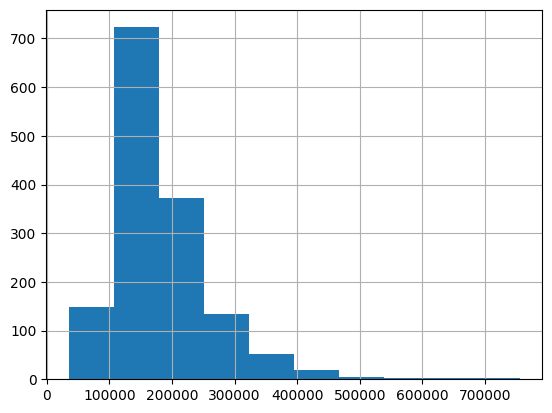

In [63]:
data["SalePrice"].hist()

In [64]:
data["SalePrice"].skew()

1.8828757597682129

The sale price is skewed to the right and may benefit from log transform.

In [65]:
#target transfo
y_log = np.log1p(y)

score_after_target_log = []
for model_name, model_instance in selected_models.items():
    print(f"testing model {model_name}")
    model_score=  {}
    results_temp = cross_validate(model_instance,
                                      X= X_train,
                                      y= y_log,
                                      cv= 5,
                                      n_jobs= -1,
                                      scoring= "neg_root_mean_squared_error")
    model_score["model"] = model_name
    model_score["score_mean"] = -results_temp["test_score"].mean()
    model_score["score_stability"] = -results_temp["test_score"].mean() + results_temp["test_score"].std()
    model_score["fit_time_mean"] = results_temp["fit_time"].mean()
    score_after_target_log.append(model_score)
    print("✅ testing done")
scores_target_log = pd.DataFrame(score_after_target_log)
scores_target_log


testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


,model,score_mean,score_stability,fit_time_mean
0,catboost,0.128514,0.134916,0.271091
1,lightgbm,0.128726,0.137563,2.460217
2,xgboost,0.136813,0.141557,0.171889
3,elasticnet,0.393485,0.409629,0.003160


## III.4 Feature selection

### Outlines

1. Tested simple selection by variance thresholding, to remove features that don't vary a lot. 
- not favored because it may remove binary features and don't see redundancy. 
- test to check how many features it would theoretically remove and impact on model. 


2. Feature permutation: 
- favored because allows to test direct impact on model, while taking into account features interactions. 
- Ideally should be tested with crossvalidation to check if feature importance is stable across fold, but dataset too small
- will measure feature importance as well as stability (importance mean / std)
- feature selected if important for at least 2 models out of 3, with threshold on importance level and on stability level

### Variance Threshold

#### Function to simplify repeated testings

In [66]:
def model_evaluation(X, y, selected_models):
    results_all_models = []
    for model_name, model_instance in selected_models.items():
        print(f"testing model {model_name}")
        model_score=  {}
        results_model = cross_validate(model_instance,
                                        X= X,
                                        y= y,
                                        cv= 5,
                                        n_jobs= -1,
                                        scoring= rmsle)
        model_score["model"] = model_name
        model_score["score_mean"] = -results_model["test_score"].mean()
        model_score["score_stability"] = -results_model["test_score"].mean() + results_model["test_score"].std()
        model_score["fit_time_mean"] = results_model["fit_time"].mean()

        results_all_models.append(model_score)
        print("✅ testing done")

    return pd.DataFrame(results_all_models)

#### Selection with var threshold 0.01

In [67]:
var_selector = VarianceThreshold(threshold= 0.01)

In [68]:
X_var = var_selector.fit_transform(X_train)


Number of features before variance thresholding: 161
Number of features after: 150
Reduction of the number of features by 6.8%


In [69]:
removed_features = [col for col in X_train.columns if col not in X_var.columns]
print("list of removed features:")
for feature in removed_features:
    print(f"  - {feature}")

list of removed features:
  - KitchenAbvGr
  - PoolQC
  - ExterCond
  - QualityScore
  - LotConfig_Other
  - Fence_Other
  - MiscFeature_Other
  - Street_Other
  - Street_Pave
  - Utilities_AllPub
  - Utilities_Other


#### Testing effect on model performance

In [70]:
df_var_1 = model_evaluation(X= X_var,
                                      y= y,
                                      selected_models= selected_models)
df_var_1

testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


,model,score_mean,score_stability,fit_time_mean
0,catboost,0.129339,0.136230,0.210671
1,lightgbm,0.133382,0.143411,2.600718
2,xgboost,0.136314,0.147584,0.166467
3,elasticnet,0.155539,0.167135,0.007151


#### Selection with Var Threshold = 0.02

In [71]:
var2_selector = VarianceThreshold(threshold= 0.02)
X_var2 = var2_selector.fit_transform(X_train)

removed_features2 = [col for col in X_train.columns if col not in X_var2.columns]
# print("list of removed features:")
# for feature in removed_features2:
#     print(f"  - {feature}")

score_var2_selector = model_evaluation(X= X_var2,
                                      y= y,
                                      selected_models= selected_models)
score_var2_selector


Number of features before variance thresholding: 161
Number of features after: 136
Reduction of the number of features by 15.5%
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


,model,score_mean,score_stability,fit_time_mean
0,catboost,0.134926,0.140473,0.211931
1,lightgbm,0.137592,0.147826,2.804733
2,xgboost,0.141115,0.150745,0.158497
3,elasticnet,0.156050,0.167655,0.005352


#### Selection with Var Threshold = 0.05

In [72]:
var3_selector = VarianceThreshold(threshold= 0.03)
X_var3 = var3_selector.fit_transform(X_train)

removed_features3 = [col for col in X_train.columns if col not in X_var3.columns]
# print("list of removed features:")
# for feature in removed_features2:
#     print(f"  - {feature}")

score_var3_selector = model_evaluation(X= X_var3,
                                      y= y,
                                      selected_models= selected_models)
score_var3_selector

Number of features before variance thresholding: 161
Number of features after: 108
Reduction of the number of features by 32.9%
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


,model,score_mean,score_stability,fit_time_mean
0,catboost,0.134881,0.143618,0.239828
1,lightgbm,0.138555,0.149668,2.594570
2,xgboost,0.141008,0.151504,0.142460
3,elasticnet,0.157039,0.168588,0.004221


**Conclusions**
Variance threshold doesn't significantly change performance:

- Removed features weren't contributing to predictions 
- Model isn't suffering from dimensionality curse 

**Next Step** : 
Test feature permutation with or without var thresholding (0.01) first. 

### Feature permutation

In [73]:
def get_feature_importance(model_name, X, y):

    model_instance = selected_models[model_name]
    model_instance.fit(X,y)
    #permutation
    print(f"testing permutation on model: {model_name} ")

    perm = permutation_importance(model_instance, X, y,
                                  n_repeats= 50,
                                  n_jobs= -1,
                                  random_state= 273,
                                  scoring= rmsle)
    #metrics
    df = pd.DataFrame({"feature": X.columns,
                       "importance_mean": perm.importances_mean,
                       "importance_std": perm.importances_std})
    df = df.sort_values(by="importance_mean", ascending= False)

    return df


def normalize_feature_importance(df):

    df["importance_norm"] = (df["importance_mean"] - df["importance_mean"].min()) / (df["importance_mean"].max() - df["importance_mean"].min())
    df["stability"] = df["importance_mean"] / (df["importance_std"] + 1e-10)  #epsilon to avoid dividinb by zero
    df["stability_norm"] = (df["stability"] - df["stability"].min()) / (df["stability"].max() - df["stability"].min())

    return df


In [74]:
#get feature importance score
importance_elasticnet = get_feature_importance("elasticnet", X_train, y)
importance_catboost = get_feature_importance("catboost", X_train, y)
importance_xgboost = get_feature_importance("xgboost", X_train, y)
importance_lightgbm = get_feature_importance("lightgbm", X_train, y)


testing permutation on model: elasticnet 
testing permutation on model: catboost 
testing permutation on model: xgboost 
testing permutation on model: lightgbm 


In [75]:
#normalize feature importance score for comparison
importance_elasticnet_norm = normalize_feature_importance(importance_elasticnet)
importance_catboost_norm = normalize_feature_importance(importance_catboost)
importance_xgboost_norm = normalize_feature_importance(importance_xgboost)
importance_lightgbm_norm = normalize_feature_importance(importance_lightgbm)


In [76]:
#merge dataframes

importance_all = importance_elasticnet_norm[["feature"]]

for model_name, df in [("elasticnet", importance_elasticnet_norm),
                   ("catboost", importance_catboost_norm),
                   ("xgboost", importance_xgboost_norm),
                   ("lightgbm", importance_lightgbm_norm)]:

    df = df.rename({"importance_norm":f"importance_{model_name}", "stability_norm": f"stability_{model_name}"}, axis = 1)
    importance_all = importance_all.merge(df[["feature", f"importance_{model_name}",f"stability_{model_name}" ]], on= "feature")


In [77]:
importance_all.head(2)

,feature,importance_elasticnet,stability_elasticnet,importance_catboost,stability_catboost,importance_xgboost,stability_xgboost,importance_lightgbm,stability_lightgbm
0,Neighborhood,1.000000,1.00000,0.519210,0.654522,0.437171,0.759184,0.396627,0.540774
1,OverallQual_GrLivArea,0.865328,0.95311,0.852013,0.850108,1.000000,1.000000,1.000000,1.000000


In [78]:
#define combined importance (linear combination of importance and stability)
importance_weight = 0.7 #this coulcatboost
stability_weight = 1 - importance_weight

importance_all["importance_mean"] = importance_all[["importance_elasticnet", "importance_catboost", "importance_xgboost", "importance_lightgbm"]].mean(axis= 1)
importance_all["stability_mean"] = importance_all[["stability_elasticnet", "stability_catboost", "stability_xgboost", "stability_lightgbm"]].mean(axis = 1)
importance_all["composite_score"] = importance_all["importance_mean"]*importance_weight + importance_all["stability_mean"]*stability_weight

Testing with top 150 features...
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
Testing with top 147 features...
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
Testing with top 143 features...
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
Testing with top 139 features...
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
Testing with top 135 features...
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
Testing with top 131 features...
testing model catboost
✅ testing done

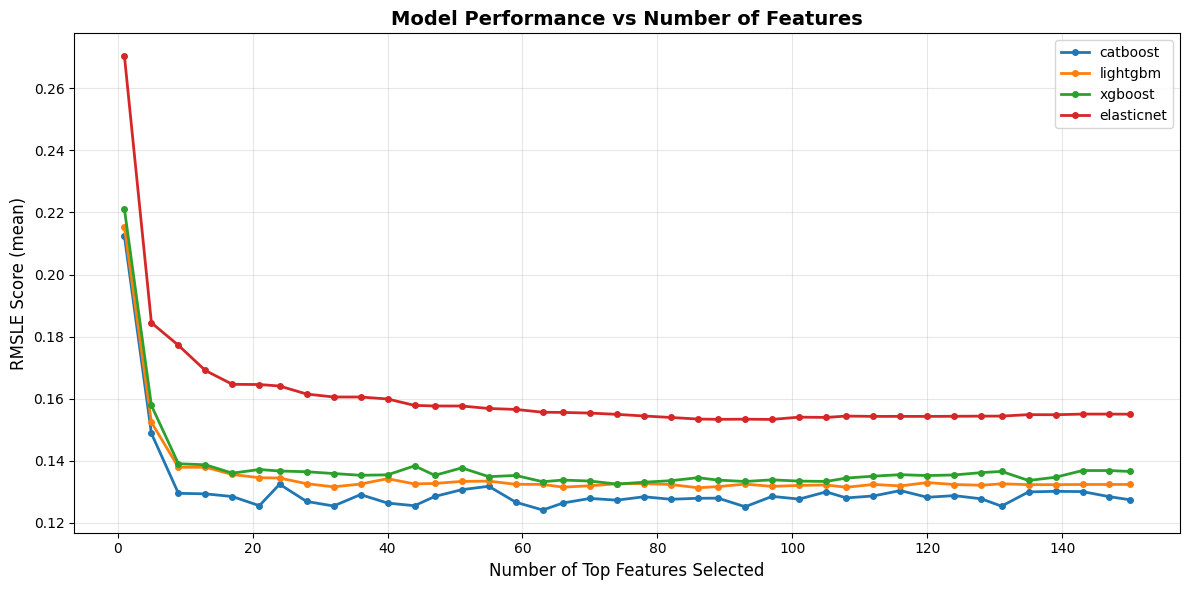

Best performance for each model:
     model  n_features  score_mean  score_stability
  catboost          63    0.124058         0.129087
elasticnet          97    0.153275         0.166224
  lightgbm          86    0.131244         0.141851
   xgboost          74    0.132425         0.142585


In [79]:
df_selected_features = []
for k in np.linspace(1, 150, 40):  # Start from 5 to avoid empty selections
    n_features = 151 - int(k)
    print(f"Testing with top {n_features} features...")

    # Select top k features based on composite score
    feat_temp = importance_all.sort_values(by="composite_score", ascending=False).head(n_features)["feature"].tolist()

    # Evaluate models
    df_temp = model_evaluation(X=X_train[feat_temp], y=y, selected_models=selected_models)

    # Add the number of features to the results
    df_temp["n_features"] = n_features

    # Append to list
    df_selected_features.append(df_temp)

# Concatenate all results
df_selected_features = pd.concat(df_selected_features, ignore_index=True)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot score_mean for each model
for model_name in df_selected_features["model"].unique():
    model_data = df_selected_features[df_selected_features["model"] == model_name]
    plt.plot(model_data["n_features"], model_data["score_mean"],
             marker='o', label=model_name, linewidth=2, markersize=4)

plt.xlabel("Number of Top Features Selected", fontsize=12)
plt.ylabel("RMSLE Score (mean)", fontsize=12)
plt.title("Model Performance vs Number of Features", fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the best configuration for each model

print("Best performance for each model:")

best_configs = df_selected_features.loc[df_selected_features.groupby("model")["score_mean"].idxmin()]
print(best_configs[["model", "n_features", "score_mean", "score_stability"]].to_string(index=False))


In [80]:
top_63 = importance_all.sort_values(by="composite_score", ascending=False).head(63)["feature"].tolist()
top_74 = importance_all.sort_values(by="composite_score", ascending=False).head(74)["feature"].tolist()
top_86 = importance_all.sort_values(by="composite_score", ascending=False).head(86)["feature"].tolist()
top_93 = importance_all.sort_values(by="composite_score", ascending=False).head(93)["feature"].tolist()
top_97 = importance_all.sort_values(by="composite_score", ascending=False).head(97)["feature"].tolist()


In [81]:
feature_configs = {
    "top_63": top_63,
    "top_74": top_74,
    "top_86": top_86,
    "top_93": top_93,
    "top_97": top_97
}
comparison_top_features = pd.DataFrame()
comparison_top_features["model"] = list(selected_models.keys())

In [82]:
for config, top_features in feature_configs.items():
    df_temp = model_evaluation(X=X_train[top_features], y=y, selected_models=selected_models)
    df_temp = df_temp.rename(columns= {"score_mean": f"score_{config}"})
    df_temp = df_temp.drop(columns= ["score_stability", "fit_time_mean"])
    comparison_top_features = comparison_top_features.merge(df_temp, on="model")


score_cols = [col for col in comparison_top_features.columns if col.startswith("score_")]
comparison_top_features["best_score"] = comparison_top_features[score_cols].min(axis=1)

for config in feature_configs.keys():
    comparison_top_features[f"%_{config}"] = (
        (comparison_top_features[f"score_{config}"] - comparison_top_features["best_score"])
        / comparison_top_features["best_score"] * 100
    )

testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done
testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


In [83]:
comparison_top_features

,model,score_top_63,score_top_74,score_top_86,score_top_93,score_top_97,best_score,%_top_63,%_top_74,%_top_86,%_top_93,%_top_97
0,catboost,0.124058,0.127243,0.127844,0.125116,0.128458,0.124058,0.000000,2.567095,3.052105,0.852823,3.546385
1,lightgbm,0.132323,0.132496,0.131244,0.132415,0.131680,0.131244,0.821589,0.953849,0.000000,0.891693,0.332098
2,xgboost,0.133184,0.132425,0.134486,0.133261,0.133790,0.132425,0.573000,0.000000,1.556377,0.631715,1.030876
3,elasticnet,0.155592,0.154905,0.153393,0.153348,0.153275,0.153275,1.511897,1.063474,0.077589,0.048113,0.000000


Comparing the different levels, it appears that the 93 features give best core on xgboost and not far from best from the other. we'll move on to that for the rest. 

In [84]:
#top features
top_93

['OverallQual_GrLivArea',
 'Neighborhood',
 'TotalSF',
 'GarageArea',
 'QualityScore',
 'BsmtFinSF1',
 'GrLivArea',
 'LotArea',
 'House_age',
 'OverallQual',
 'MSSubClass',
 'Remodelled_age',
 'SaleCondition_Abnorml',
 'TotalBsmtSF',
 'FireplaceQu',
 '1stFlrSF',
 'KitchenQual',
 'MasVnrArea',
 'OverallCond',
 'TotalBath',
 'GarageCars',
 'BsmtUnfSF',
 'CentralAir_N',
 'OpenPorchSF',
 'Exterior1st',
 'WoodDeckSF',
 'GarageFinish',
 'MSZoning_Other',
 'Garage_age',
 'TotalPorch',
 'TotalSFperRoom',
 'HeatingQC',
 'LotFrontage',
 'BsmtExposure',
 '2ndFlrSF',
 'Exterior2nd',
 'Functional_Typ',
 'MoSold',
 'TotRmsAbvGrd',
 'Fireplaces',
 'Condition1_Norm',
 'ExterCond',
 'ScreenPorch',
 'BsmtFinType1_GLQ',
 'BsmtQual',
 'PavedDrive_Y',
 'BsmtFullBath',
 'BedroomAbvGr',
 'GarageCond',
 'SaleCondition_Other',
 'GarageQual',
 'ExterQual',
 'Condition1_Artery',
 'Functional_Other',
 'MSZoning_RL',
 'SaleType_New',
 'EnclosedPorch',
 'MSZoning_RM',
 'BsmtCond',
 'SaleCondition_Normal',
 'Central

## III.5 Model Tuning

In [85]:
selected_models = {
    'catboost': CatBoostRegressor(iterations=100, random_state=42, verbose=0),
    'lightgbm': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'xgboost': XGBRegressor(n_estimators=100, random_state=42),
    'elasticnet': ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=42)
}

In [86]:
X_selected = X_train[top_93]

In [87]:
import pickle
from pathlib import Path

# Creating folder
Path("models").mkdir(exist_ok=True)

#### Tuning CatBoost

In [88]:
def objective_catboost(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log= True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "random_state": random_state,
        "verbose": 0,
        "eval_metric": "RMSE"
    }

    model = CatBoostRegressor(**params)
    score = cross_val_score(model, X_selected, y, cv= 5, scoring= rmsle, n_jobs= -1)
    return -score.mean()

In [89]:
from optuna.samplers import TPESampler

study_catboost = optuna.create_study(
    direction = "minimize",
    sampler= TPESampler(seed= random_state),
    pruner= optuna.pruners.MedianPruner(n_startup_trials= 10, n_warmup_steps= 5)
)

study_catboost.optimize(objective_catboost, n_trials= 100, show_progress_bar= True)

print(f"best params: {study_catboost.best_params}")
print(f"Best score: {study_catboost.best_value}")

optuna.visualization.plot_optimization_history(study_catboost)


[I 2026-01-19 13:00:28,106] A new study created in memory with name: no-name-d6e58369-90aa-4be8-95f3-15e920bceb47


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-19 13:00:28,430] Trial 0 finished with value: 0.14857690397736514 and parameters: {'iterations': 310, 'learning_rate': 0.012471842879599663, 'depth': 4, 'l2_leaf_reg': 1.0437457839349058, 'subsample': 0.8053312407869989, 'colsample_bylevel': 0.9668516368588292, 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.14857690397736514.
[I 2026-01-19 13:00:36,831] Trial 1 finished with value: 0.12859654004029206 and parameters: {'iterations': 2114, 'learning_rate': 0.25759774886641296, 'depth': 7, 'l2_leaf_reg': 1.2610602643172677, 'subsample': 0.8015509018748495, 'colsample_bylevel': 0.6467809281620903, 'min_data_in_leaf': 24}. Best is trial 1 with value: 0.12859654004029206.
[I 2026-01-19 13:00:55,714] Trial 2 finished with value: 0.12346704115358138 and parameters: {'iterations': 1443, 'learning_rate': 0.021374592349975963, 'depth': 9, 'l2_leaf_reg': 9.461033317410196, 'subsample': 0.9231652043299112, 'colsample_bylevel': 0.7216400362545861, 'min_data_in_leaf': 48}. Best is 

/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2026-01-19 13:00:57,253] Trial 3 finished with value: 0.1286428988241298 and parameters: {'iterations': 258, 'learning_rate': 0.2951570249955508, 'depth': 5, 'l2_leaf_reg': 4.3818763120054545, 'subsample': 0.8767675999149871, 'colsample_bylevel': 0.9585501673855075, 'min_data_in_leaf': 49}. Best is trial 2 with value: 0.12346704115358138.
[I 2026-01-19 13:00:58,318] Trial 4 finished with value: 0.12229917181722412 and parameters: {'iterations': 396, 'learning_rate': 0.10527756747285869, 'depth': 4, 'l2_leaf_reg': 6.91143551516566, 'subsample': 0.8258144402994527, 'colsample_bylevel': 0.8050395174100358, 'min_data_in_leaf': 3}. Best is trial 4 with value: 0.12229917181722412.
[I 2026-01-19 13:01:01,620] Trial 5 finished with value: 0.12273824155540196 and parameters: {'iterations': 719, 'learning_rate': 0.13257803633048953, 'depth': 7, 'l2_leaf_reg': 6.7410382526994965, 'subsample': 0.6164804768532888, 'colsample_bylevel': 0.8450894401133585, 'min_data_in_leaf': 32}. Best is trial 4 

In [90]:
optuna.visualization.plot_param_importances(study_catboost)

In [116]:
best_params_catboost = study_catboost.best_params.copy()
best_params_catboost['verbose'] = 0
best_params_catboost['random_state'] = 273

print(f"  Catboost Best params: {best_params_catboost}")
best_catboost = CatBoostRegressor(**best_params_catboost)



with open(f"models/best_catboost.pkl", "wb") as f:
    pickle.dump(best_catboost, f)


  Catboost Best params: {'iterations': 1576, 'learning_rate': 0.02188429195249318, 'depth': 6, 'l2_leaf_reg': 1.8076026169908315, 'subsample': 0.8403865117776631, 'colsample_bylevel': 0.6210099039123392, 'min_data_in_leaf': 26, 'verbose': 0, 'random_state': 273}


### Optimization LIGHTGBM

In [92]:
def objective_lightgbm(trial):

    params= {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log= True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log= True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "random_state": random_state,
        "verbose": -1,
        "n_jobs" : -1

        }

    model = LGBMRegressor(**params)
    score = cross_val_score(model, X_selected, y, cv= 5, scoring= rmsle, n_jobs= -1)
    return -score.mean()

In [93]:
study_lgbm = optuna.create_study(
    direction = "minimize",
    sampler= TPESampler(seed= random_state),
    pruner= optuna.pruners.MedianPruner(n_startup_trials= 10, n_warmup_steps= 5)
)

study_lgbm.optimize(objective_lightgbm, n_trials= 100, show_progress_bar= True)

print(f"best params: {study_lgbm.best_params}")
print(f"Best score: {study_lgbm.best_value}")

optuna.visualization.plot_optimization_history(study_lgbm)


[I 2026-01-19 13:10:08,823] A new study created in memory with name: no-name-3dcc0eca-4d26-48af-b691-d3f491d4de00


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-19 13:10:10,764] Trial 0 finished with value: 0.14236800476915465 and parameters: {'n_estimators': 310, 'learning_rate': 0.012471842879599663, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 54, 'reg_alpha': 1.7954025154797872, 'reg_lambda': 0.08741958478198075, 'subsample': 0.8777355529875626, 'colsample_bytree': 0.9820788737333042, 'subsample_freq': 4}. Best is trial 0 with value: 0.14236800476915465.
[I 2026-01-19 13:10:12,826] Trial 1 finished with value: 0.13049691515194237 and parameters: {'n_estimators': 184, 'learning_rate': 0.05549933797567372, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 49, 'reg_alpha': 1.0233996246412147e-06, 'reg_lambda': 0.04927864715864389, 'subsample': 0.976045925218231, 'colsample_bytree': 0.9231652043299112, 'subsample_freq': 3}. Best is trial 1 with value: 0.13049691515194237.
[I 2026-01-19 13:10:30,777] Trial 2 finished with value: 0.12786307073825717 and parameters: {'n_estimators': 2843, 'learning_rate': 0.0120477407309

In [94]:
optuna.visualization.plot_param_importances(study_lgbm)

In [ ]:
best_params_lightgbm = study_lgbm.best_params.copy()
best_params_lightgbm['verbose'] = -1
best_params_lightgbm['random_state'] = random_state
best_params_lightgbm['n_jobs'] = -1
print(f"  lightgbm Best params: {best_params_lightgbm}")
best_lightgbm = LGBMRegressor(**best_params_lightgbm)


with open(f"models/best_lightgbm.pkl", "wb") as f:
    pickle.dump(best_lightgbm, f)

  lightgbm Best params: {'n_estimators': 2939, 'learning_rate': 0.012801905082397435, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 10, 'reg_alpha': 6.959002880471379e-08, 'reg_lambda': 2.9123498664962653, 'subsample': 0.7050245929062413, 'colsample_bytree': 0.68096023613566, 'subsample_freq': 1, 'verbose': -1, 'random_state': 273, 'n_jobs': -1}


### Optimization XGBOOST

In [96]:
def objective_xgboost(trial):

    params= {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log= True),

        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log= True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log= True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log= True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": random_state,
        "tree_method": "hist",
        "n_jobs" : -1
        }

    model = XGBRegressor(**params)
    score = cross_val_score(model, X_selected, y, cv= 5, scoring= rmsle, n_jobs= -1)
    return -score.mean()

In [97]:
study_xgb = optuna.create_study(
    direction = "minimize",
    sampler= TPESampler(seed= random_state),
    pruner= optuna.pruners.MedianPruner(n_startup_trials= 10, n_warmup_steps= 5)
)

study_xgb.optimize(objective_xgboost, n_trials= 100, show_progress_bar= True)

print(f"best params: {study_xgb.best_params}")
print(f"Best score: {study_xgb.best_value}")

optuna.visualization.plot_optimization_history(study_xgb)

[I 2026-01-19 13:41:10,309] A new study created in memory with name: no-name-b68a788e-48ac-407d-b523-c3e2f8ba19b9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-19 13:41:10,486] Trial 0 finished with value: 0.13934675296443508 and parameters: {'n_estimators': 310, 'learning_rate': 0.012471842879599663, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.0001278276532000667, 'reg_alpha': 1.7954025154797872, 'reg_lambda': 0.08741958478198075, 'subsample': 0.8777355529875626, 'colsample_bytree': 0.9820788737333042}. Best is trial 0 with value: 0.13934675296443508.
[I 2026-01-19 13:41:14,147] Trial 1 finished with value: 0.1319375463541241 and parameters: {'n_estimators': 1422, 'learning_rate': 0.011036882200620338, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 4.975324975089151e-05, 'reg_alpha': 0.0001469788653862949, 'reg_lambda': 1.0233996246412147e-06, 'subsample': 0.8974515011858093, 'colsample_bytree': 0.976045925218231}. Best is trial 1 with value: 0.1319375463541241.
[I 2026-01-19 13:41:20,457] Trial 2 finished with value: 0.1370724289718775 and parameters: {'n_estimators': 2443, 'learning_rate': 0.028131488187483754, 'max_depth

In [98]:
optuna.visualization.plot_param_importances(study_xgb)

In [ ]:
best_params_xgboost = study_xgb.best_params.copy()
best_params_xgboost['verbosity'] = 0
best_params_xgboost['random_state'] = random_state
best_params_xgboost['n_jobs'] = -1
print(f"  XGBOOST Best params: {best_params_xgboost}")
best_xgboost = XGBRegressor(**best_params_xgboost)


with open(f"models/best_xgboost.pkl", "wb") as f:
    pickle.dump(best_xgboost, f)

  XGBOOST Best params: {'n_estimators': 2803, 'learning_rate': 0.011760885607467755, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.0005152122571568215, 'reg_alpha': 0.0005223397340600925, 'reg_lambda': 0.22169327984518003, 'subsample': 0.6728030261391712, 'colsample_bytree': 0.600207907152343, 'verbosity': 0, 'random_state': 273, 'n_jobs': -1}


### optimization ElasticNet

In [100]:
def objective_elasticnet(trial):

    params= {
        "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log= True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "max_iter": 50000,
        "random_state": random_state,
        "selection": trial.suggest_categorical("selection", ["cyclic", "random"]),
        "tol": 1e-3
        }

    model = ElasticNet(**params)
    score = cross_val_score(model, X_selected, y, cv= 5, scoring= rmsle, n_jobs= -1)
    return -score.mean()

In [101]:
study_elasticnet = optuna.create_study(
    direction = "minimize",
    sampler= TPESampler(seed= random_state),
    pruner= optuna.pruners.MedianPruner(n_startup_trials= 10, n_warmup_steps= 5)
)

study_elasticnet.optimize(objective_elasticnet, n_trials= 100, show_progress_bar= True)

print(f"best params: {study_elasticnet.best_params}")
print(f"Best score: {study_elasticnet.best_value}")

optuna.visualization.plot_optimization_history(study_elasticnet)

[I 2026-01-19 13:44:10,300] A new study created in memory with name: no-name-6d5411fb-1c51-4499-a2b2-6fcf3e23ccc4


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p
/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:11,602] Trial 0 finished with value: 0.16687202300822004 and parameters: {'alpha': 0.00023101641864865896, 'l1_ratio': 0.06494431696960623, 'selection': 'cyclic'}. Best is trial 0 with value: 0.16687202300822004.
[I 2026-01-19 13:44:11,751] Trial 1 finished with value: 0.15687056082430653 and parameters: {'alpha': 0.0368672301268113, 'l1_ratio': 0.917129092147073, 'selection': 'cyclic'}. Best is trial 1 with value: 0.15687056082430653.
[I 2026-01-19 13:44:11,824] Trial 2 finished with value: 0.21471601878031327 and parameters: {'alpha': 5.970159330665548, 'l1_ratio': 0.45582568789386935, 'selection': 'random'}. Best is trial 1 with value: 0.15687056082430653.


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:12,827] Trial 3 finished with value: 0.1670240658719529 and parameters: {'alpha': 0.00038438072538821204, 'l1_ratio': 0.46210268162211743, 'selection': 'cyclic'}. Best is trial 1 with value: 0.15687056082430653.
[I 2026-01-19 13:44:12,911] Trial 4 finished with value: 0.1459631618066008 and parameters: {'alpha': 0.5225691468204046, 'l1_ratio': 0.9401148130455774, 'selection': 'cyclic'}. Best is trial 4 with value: 0.1459631618066008.
[I 2026-01-19 13:44:12,983] Trial 5 finished with value: 0.2435021073224143 and parameters: {'alpha': 5.350000605052113, 'l1_ratio': 0.05477249252297334, 'selection': 'cyclic'}. Best is trial 4 with value: 0.1459631618066008.


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:13,135] Trial 6 finished with value: 0.15819896661343907 and parameters: {'alpha': 0.007565195809747269, 'l1_ratio': 0.6919189997874677, 'selection': 'random'}. Best is trial 4 with value: 0.1459631618066008.


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.848e+11, tolerance: 7.592e+09
  model = cd_fast.enet_coordinate_descent(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.033e+11, tolerance: 7.288e+09
  model = cd_fast.enet_coordinate_descent(
/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-

[I 2026-01-19 13:44:15,810] Trial 7 finished with value: 0.16934930136006277 and parameters: {'alpha': 0.00032390408752092494, 'l1_ratio': 0.6921136896367468, 'selection': 'random'}. Best is trial 4 with value: 0.1459631618066008.
[I 2026-01-19 13:44:15,885] Trial 8 finished with value: 0.14577335527770846 and parameters: {'alpha': 0.06647839164639108, 'l1_ratio': 0.5125987935250894, 'selection': 'random'}. Best is trial 8 with value: 0.14577335527770846.
[I 2026-01-19 13:44:15,911] Trial 9 finished with value: 0.15004943523880726 and parameters: {'alpha': 0.6302664232245155, 'l1_ratio': 0.43612823737238504, 'selection': 'cyclic'}. Best is trial 8 with value: 0.14577335527770846.
[I 2026-01-19 13:44:16,002] Trial 10 finished with value: 0.1537063387563129 and parameters: {'alpha': 0.018228024088154847, 'l1_ratio': 0.28109556446679623, 'selection': 'random'}. Best is trial 8 with value: 0.14577335527770846.


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:16,150] Trial 11 finished with value: 0.1564609884781762 and parameters: {'alpha': 0.16938175096626185, 'l1_ratio': 0.9805438711623875, 'selection': 'random'}. Best is trial 8 with value: 0.14577335527770846.
[I 2026-01-19 13:44:16,181] Trial 12 finished with value: 0.143604618334638 and parameters: {'alpha': 0.4327927991331453, 'l1_ratio': 0.7811386266535064, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:16,220] Trial 13 finished with value: 0.14613630663617155 and parameters: {'alpha': 0.11174983394078734, 'l1_ratio': 0.7273538107550044, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:16,691] Trial 14 finished with value: 0.1629861883108737 and parameters: {'alpha': 0.0030345926899632285, 'l1_ratio': 0.7817380478122113, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:16,722] Trial 15 finished with value: 0.15451985247255867 and parameters: {'alpha': 1.3459344091832541, 'l1_ratio': 0.5901365568404706, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:16,752] Trial 16 finished with value: 0.14382390386799143 and parameters: {'alpha': 0.15041273021766083, 'l1_ratio': 0.2922678375510129, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:16,778] Trial 17 finished with value: 0.1463863519554453 and parameters: {'alpha': 0.2763172618347011, 'l1_ratio': 0.2544645624777408, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:16,796] Trial 18 finished with value: 0.17281932845636686 and para

/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:17,044] Trial 19 finished with value: 0.16005561948465735 and parameters: {'alpha': 0.0023402922917723948, 'l1_ratio': 0.35452796710527634, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:17,073] Trial 20 finished with value: 0.14685233743073353 and parameters: {'alpha': 1.4163713211065418, 'l1_ratio': 0.842131307347976, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:17,117] Trial 21 finished with value: 0.14864887484228004 and parameters: {'alpha': 0.0512690601168636, 'l1_ratio': 0.5791530210330642, 'selection': 'random'}. Best is trial 12 with value: 0.143604618334638.
[I 2026-01-19 13:44:17,143] Trial 22 finished with value: 0.14345021339055347 and parameters: {'alpha': 0.07923159484313823, 'l1_ratio': 0.15711518818773637, 'selection': 'random'}. Best is trial 22 with value: 0.14345021339055347.
[I 2026-01-19 13:44:17,196] Trial 23 finished with value: 0.1507735424763778 and 

/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:17,497] Trial 28 finished with value: 0.15653988294843899 and parameters: {'alpha': 0.0037725906087243315, 'l1_ratio': 0.13623060414295174, 'selection': 'random'}. Best is trial 27 with value: 0.14341437832200823.


/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:17,797] Trial 29 finished with value: 0.16245826985696446 and parameters: {'alpha': 0.000872240338856955, 'l1_ratio': 0.11204701258287489, 'selection': 'cyclic'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:17,826] Trial 30 finished with value: 0.14354266019881973 and parameters: {'alpha': 0.07547581062937236, 'l1_ratio': 0.19219112914396141, 'selection': 'random'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:17,857] Trial 31 finished with value: 0.1442686592746759 and parameters: {'alpha': 0.05697563053937484, 'l1_ratio': 0.21055818223228362, 'selection': 'random'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:17,933] Trial 32 finished with value: 0.1614963499342567 and parameters: {'alpha': 0.008400874813313208, 'l1_ratio': 0.07528866060854304, 'selection': 'random'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:17,964] Trial 33 finished with value: 0.143433402695

/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:20,124] Trial 38 finished with value: 0.16860570312088813 and parameters: {'alpha': 0.0001325782470841164, 'l1_ratio': 0.033081496281149717, 'selection': 'cyclic'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:20,155] Trial 39 finished with value: 0.15846947089461744 and parameters: {'alpha': 0.7927298309897373, 'l1_ratio': 0.08616259465769482, 'selection': 'cyclic'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:20,171] Trial 40 finished with value: 0.25816722330471664 and parameters: {'alpha': 9.579518793123658, 'l1_ratio': 0.34787995604071986, 'selection': 'cyclic'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:20,201] Trial 41 finished with value: 0.1436439606212155 and parameters: {'alpha': 0.07151018818535991, 'l1_ratio': 0.20123600963112306, 'selection': 'random'}. Best is trial 27 with value: 0.14341437832200823.
[I 2026-01-19 13:44:20,230] Trial 42 finished with value: 0.1434372440208

/var/folders/dk/v6_xfc950bb08vyf1lm9v0x00000gn/T/ipykernel_23631/1955747760.py:9: RuntimeWarning: invalid value encountered in log1p


[I 2026-01-19 13:44:22,067] Trial 80 finished with value: 0.16412881591683687 and parameters: {'alpha': 0.004922708946232999, 'l1_ratio': 0.9039359804118616, 'selection': 'random'}. Best is trial 62 with value: 0.1434141237057222.
[I 2026-01-19 13:44:22,097] Trial 81 finished with value: 0.1434470869486138 and parameters: {'alpha': 0.07442746608363536, 'l1_ratio': 0.09860322070970737, 'selection': 'random'}. Best is trial 62 with value: 0.1434141237057222.
[I 2026-01-19 13:44:22,126] Trial 82 finished with value: 0.14342800656937324 and parameters: {'alpha': 0.08974402543915165, 'l1_ratio': 0.11573718719631684, 'selection': 'random'}. Best is trial 62 with value: 0.1434141237057222.
[I 2026-01-19 13:44:22,155] Trial 83 finished with value: 0.14504359781279957 and parameters: {'alpha': 0.042917230972908664, 'l1_ratio': 0.13209034617482762, 'selection': 'random'}. Best is trial 62 with value: 0.1434141237057222.
[I 2026-01-19 13:44:22,185] Trial 84 finished with value: 0.1434659732810189

In [102]:
optuna.visualization.plot_param_importances(study_elasticnet)

In [119]:
best_params_elasticnet = study_elasticnet.best_params.copy()
print(f"  ElasticNet Best params: {best_params_elasticnet}")
best_elasticnet = ElasticNet(**best_params_elasticnet)


with open(f"models/best_elasticnet.pkl", "wb") as f:
    pickle.dump(best_elasticnet, f)

  ElasticNet Best params: {'alpha': 0.08406752483016589, 'l1_ratio': 0.13147335970295876, 'selection': 'random'}


In [104]:
print(f"  ✅ Saved to models/best_{model_name}.pkl")

  ✅ Saved to models/best_elasticnet.pkl


#### test of saved model

In [120]:
with open("models/best_catboost.pkl", "rb") as f:
    best_catboost= pickle.load(f)


with open("models/best_lightgbm.pkl", "rb") as f:
    best_lightgbm= pickle.load(f)


with open("models/best_xgboost.pkl", "rb") as f:
    best_xgboost= pickle.load(f)


with open("models/best_elasticnet.pkl", "rb") as f:
    best_elasticnet= pickle.load(f)

In [121]:
best_models = {"catboost": best_catboost,
               "lightgbm": best_lightgbm,
               "xgboost": best_xgboost,
               "elasticnet": best_elasticnet}

best_results = model_evaluation(X= X_selected, y= y, selected_models= best_models)

testing model catboost
✅ testing done
testing model lightgbm
✅ testing done
testing model xgboost
✅ testing done
testing model elasticnet
✅ testing done


In [122]:
best_results

,model,score_mean,score_stability,fit_time_mean
0,catboost,0.117116,0.124981,3.444603
1,lightgbm,0.122340,0.130668,20.617074
2,xgboost,0.119595,0.130589,1.146721
3,elasticnet,0.143414,0.155533,0.008425


## III.6 Model Stacking

In [123]:
from sklearn.ensemble import StackingRegressor

#### Stacking configuration without passthrough

In [124]:
estimators = [
    ("catboost", best_catboost),
    ("xgboost", best_xgboost),
    ("lightgbm", best_lightgbm)
]

# meta_model
meta_model = Ridge(alpha= 10)

In [125]:
#stacking
stacked_model = StackingRegressor(
    estimators= estimators,
    final_estimator= meta_model,
    cv= 5,
    n_jobs= -1,
    passthrough= False #let's test like this first, then with True
)

In [129]:
# training, passthrough = False
stacking_cv_scores = cross_val_score(estimator= stacked_model,
                                     X= X_selected, y= y, cv= 10, scoring= rmsle, n_jobs= -1)

print(f"CV score of stacked model without passthrough {-stacking_cv_scores.mean()}")

/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has featu

CV score of stacked model without passthrough 0.11645430698224805


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


### Stacking configuration with passthrough

In [130]:
stacked_model_passthrough = StackingRegressor(
    estimators= estimators,
    final_estimator= meta_model,
    cv= 5,
    n_jobs= -1,
    passthrough= True #let's test like this first, then with True
)

In [ ]:
# training, passthrough = False
stacking_cv_scores_passthrough = cross_val_score(estimator= stacked_model_passthrough,
                                     X= X_selected, y= y, cv= 10, scoring= rmsle, n_jobs= -1)

print(f"CV score of stacked model with passthrough {-stacking_cv_scores_passthrough.mean()}")

/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has featu

CV score of stacked model without passthrough 0.12475416143882316


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


#### Tuning stacked model (without passthrough)

**no effect of tuning on stacked model: probably model good enough and correlated. metamodel doesnt really improved**

### Trying to add random forest for different approach 

In [136]:
model_rf = models["random_forest"]

rf_score = -cross_val_score(model_rf, X= X_selected, y = y, cv= 5, n_jobs= -1, scoring= rmsle).mean()


In [137]:
rf_score

0.13807873664225795

In [ ]:
#tuning random forest
def objective_random_forest(trial):

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'max_depth': trial.suggest_int('max_depth', 5, 30),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    'max_samples': trial.suggest_float('max_samples', 0.6, 1.0),
    'bootstrap': True,
    'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',
                                                      0.0, 0.01),
    "random_state" : 273,
    "n_jobs" : -1,
    "verbose" : 0
}

    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X_selected, y, cv= 5, scoring = rmsle, n_jobs= -1)
    return -scores.mean()

study_rf = optuna.create_study(direction= "minimize",
                                     sampler= TPESampler(seed= random_state),
                                     pruner= optuna.pruners.MedianPruner(n_min_trials= 10, n_warmup_steps= 5)
                                     )
study_rf.optimize(objective_random_forest, n_trials= 100, show_progress_bar= True)


[I 2026-01-19 16:19:55,689] A new study created in memory with name: no-name-5ed37f0b-42e1-4dd9-b443-f00655dc64e8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-19 16:19:57,538] Trial 0 finished with value: 0.15408375922235865 and parameters: {'n_estimators': 165, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_samples': 0.8777355529875626, 'min_impurity_decrease': 0.009551971843332603}. Best is trial 0 with value: 0.15408375922235865.
[I 2026-01-19 16:19:58,532] Trial 1 finished with value: 0.16385212522649414 and parameters: {'n_estimators': 510, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.8974515011858093, 'min_impurity_decrease': 0.009401148130455774}. Best is trial 0 with value: 0.15408375922235865.
[I 2026-01-19 16:19:59,734] Trial 2 finished with value: 0.14227334215217488 and parameters: {'n_estimators': 827, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_samples': 0.8767675999149871, 'min_impurity_decrease': 0.008963754184637686}. Best is trial 2 with value: 0.14227334215217

In [149]:
best_params_rf = study_rf.best_params.copy()
best_rf = RandomForestRegressor(**best_params_rf)
with open("models/best_rf.pkl", "wb") as f:
    pickle.dump(best_rf, f)

In [150]:
with open("models/best_rf.pkl", "rb") as f:
    best_rf= pickle.load(f)

In [151]:
test = -cross_val_score(best_rf, X_selected, y, cv= 5, scoring= rmsle, n_jobs= -1)

In [154]:
estimators_rf  = [
    ("catboost", best_catboost),
    ("xgboost", best_xgboost),
    ("lightgbm", best_lightgbm),
    ("rf", best_rf)
]

# meta_model
meta_model_rf = Ridge(alpha= 10)

#stacking
stacked_model_rf = StackingRegressor(
    estimators= estimators_rf,
    final_estimator= meta_model_rf,
    cv= 5,
    n_jobs= -1,
    passthrough= False #let's test like this first, then with True
)

# training, passthrough = False
stacking_cv_scores_rf = cross_val_score(estimator= stacked_model_rf,
                                     X= X_selected, y= y, cv= 10, scoring= rmsle, n_jobs= -1)

print(f"CV score of stacked model without passthrough {-stacking_cv_scores_rf.mean()}")


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has featu

CV score of stacked model without passthrough 0.1178530620894103


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


#add random forest worsen things. 

In [ ]:
estimators_no_rf  = [
    ("catboost", best_catboost),
    ("xgboost", best_xgboost),
    ("lightgbm", best_lightgbm)

]

# meta_model
meta_model_no_rf = Ridge(alpha= 10)

#stacking
stacked_model_no_rf = StackingRegressor(
    estimators= estimators_no_rf,
    final_estimator= meta_model_no_rf,
    cv= 5,
    n_jobs= -1,
    passthrough= False #let's test like this first, then with True
)

# training, passthrough = False
stacking_cv_scores_no_rf = cross_val_score(estimator= stacked_model_no_rf,
                                     X= X_selected, y= y, cv= 10, scoring= rmsle, n_jobs= -1)

print(f"CV score of stacked model without passthrough {-stacking_cv_scores_no_rf.mean()}")

/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has featu

CV score of stacked model without passthrough 0.11645430698224805


/Users/pablorougerie/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [156]:
cv_scores_best_catboost = cross_val_score(estimator= best_catboost,
                                     X= X_selected, y= y, cv= 10, scoring= rmsle, n_jobs= -1)

print(f"CV score of stacked model without passthrough {-cv_scores_best_catboost.mean()}")

CV score of stacked model without passthrough 0.11587873847409838


In [157]:
best_catboost.fit(X_selected, y)

In [158]:
y_pred_model = best_catboost.predict(X_test)

In [161]:
results = pd.concat([pd.Series(X_test_ids, name= "ID"), pd.Series(y_pred_model, name= "SalePrice")], axis= 1)
results.to_csv("data/model_submission.csv", header= True, index= False)

## Conclusion

This notebook presents a comprehensive approach to predicting house prices using advanced regression techniques.

### Key Achievements:

- **Preprocessing Pipeline**: Implemented a robust sklearn pipeline with custom transformers for conditional imputation, feature engineering, and proper encoding/scaling strategies.

- **Feature Engineering**: Created age features, handled zero-inflated distributions, and applied appropriate transformations (log, cyclical) based on EDA insights.

- **Model Selection**: Evaluated multiple models (linear, tree-based, boosting) and selected the best performers (CatBoost, XGBoost, LightGBM).

- **Hyperparameter Tuning**: Used Optuna for automated hyperparameter optimization across all selected models.

- **Ensemble Method**: Implemented a stacking regressor combining the best models with a Ridge meta-learner.

### Final Results:

**Kaggle Test Submission Score: 0.12175**

This represents a significant improvement from the initial baseline and demonstrates the effectiveness of the comprehensive preprocessing pipeline and ensemble approach.